In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
#this will cause text to be exported as 'true text' which can be edited in Adobe Illustrator
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_CSvsTrace_FIGURES'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'add_significance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'add_significance_line', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'add_significance_line_chance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'report_stats', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'report_stats_chance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'sig_vs_chance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [5]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [6]:
def report_stats (array1, array2, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        U = sig_func(array1, array2)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        p = sig_func(array1, array2)[-1]
        print "U =",U,"p =",p*mcc,"r =",r
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        cohens_d = (np.mean(array1)-np.mean(array2))/np.sqrt((np.std(array1)**2+np.std(array2)**2)/2)
        p = sig_func(array1, array2)[-1]
        print sig_func(array1, array2),"d =", cohens_d, 'corrected p =',p*mcc
    if sig_func is 'fishers':
        table = array1,array2
        sig_func = lambda x: sstats.fisher_exact(x, alternative='two-sided')
        p = sig_func(table)[-1]
        odds_ratio = sig_func(table)[0]
        print "odd's ratio =", odds_ratio, 'corrected p =',p*mcc
        

def report_stats_chance (array1, chance=0.5, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        U = sig_func(subtracted)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        print sig_func(subtracted),"r =",r
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        cohens_d = (np.mean(array1)-chance)/np.std(array1)
        print sig_func(array1,chance),"d =",cohens_d

In [7]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [8]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        p = sig_func(array1, array2)[-1]
        sig_value = sig_func(array1, array2)[0]
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        p = sig_func(array1, array2)[-1]
        sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'p=%.3f'%(p*mcc) if (.05/mcc)<p<(.1/mcc) else
            'n.s.' if p > thresholds[0]/mcc else
            '*' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=5)
    return sig_value, p

In [9]:
import matplotlib.lines
from matplotlib.lines import Line2D
def add_significance_line(ax, array1, array2, x1, x2, y, color1='b',color2='r',thresh=0.05, sig_func=None, thresholds=(0.05, 0.01, 0.001),lines=True,stars=True,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    if lines==True:
        if p < thresh/mcc:
            if np.mean(array1) > np.mean(array2):
                line = Line2D([x1, x2], [y,y], lw=1, color=color1, clip_on=False)
            if np.mean(array1) < np.mean(array2):
                line = Line2D([x1, x2], [y,y], lw=1, color=color2, clip_on=False)
            ax.add_line(line)
    if stars == True:
        ax.text(np.mean([x1, x2]), y+1,
            '' if p > thresholds[0]/mcc else
            '' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=5)
    return sig_value, p

In [10]:
import matplotlib.lines
from matplotlib.lines import Line2D
def add_significance_line_chance(ax, array1, chance, x1, x2, y, color='b',thresh=0.05, sig_func=None, thresholds=(0.05, 0.01, 0.001),lines=True,stars=True,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    if lines==True:
        if p < thresh/mcc:
            line = Line2D([x1, x2], [y,y], lw=1, color=color, clip_on=False)
            ax.add_line(line)
    if stars == True:
        ax.text(np.mean([x1, x2]), y+1,
            '' if p > thresholds[0]/mcc else
            '*' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=5)
    return sig_value, p

In [10]:
sessions = 'expo', 'pre','d2', 'post','ext1','ext2','renew'

for reference:

delta_t0 = 1

t_start0 = -5  # sec

t_stop0 = 11  # sec

In [11]:
trad_co = ('limegreen','b','r','silver','grey','y')
pal_co = ('#003f5c','#444e86','#955196','#dd5182','#ff6e54','#ffa600')
dark_co = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
dark_co_b = ('forestgreen','darkcyan','rebeccapurple','firebrick','lightgrey','dimgrey','goldenrod')
alt_co = ('hotpink','mediumorchid','darkturquoise','mediumspringgreen','lawngreen','khaki')
session_labels = ('Pre','Early','Late','Ext1','Ext2','Reacq')
session_labels_b = ('Pre','Early','Day2','Late','Ext1','Ext2','Reacq')

comparisons = ['CSp','CSm']
comp_labels = ['CS+','CS-']
comp_colors = ['m','c']

In [13]:
v_name=[]
for t in range(16):
    for comp in comparisons:
        for r in 'dhpc','vhpc':
            exec("baseline_scores_tb_%s_%s_%s = {}"%(t,comp,r))
            for sess in sessions:
                exec("v_name = 'baseline_scores_gmin_tb_%s_%s'"%(t,comp))
                exec("path='../notebooks/autorestore/decoding_CSvsTrace_%s/'"%(r))
                exec("baseline_scores_tb_%s_%s_%s_t = ut.load_variable(v_name,path)"%(t,comp,r))
                exec("baseline_scores_tb_%s_%s_%s_t = baseline_scores_tb_%s_%s_%s_t['%s']"%(t,comp,r,t,comp,r,sess))
                exec("baseline_scores_tb_%s_%s_%s['%s'] = baseline_scores_tb_%s_%s_%s_t"%(t,comp,r,sess,t,comp,r))

In [14]:
loops=10
for t in range (16):
    for comp in comparisons:
        exec("ttest_tb_%s_%s = {}"%(t,comp))
        exec("mannwhitU_tb_%s_%s = {}"%(t,comp))
        for sess in sessions:
            exec("ttest_tb_%s_%s[sess] = sstats.ttest_ind(baseline_scores_tb_%s_%s_dhpc[sess][:loops],baseline_scores_tb_%s_%s_vhpc[sess][:loops])"%(t,comp,t,comp,t,comp))
            exec("mannwhitU_tb_%s_%s[sess] = sstats.mannwhitneyu(baseline_scores_tb_%s_%s_dhpc[sess][:loops],baseline_scores_tb_%s_%s_vhpc[sess][:loops])"%(t,comp,t,comp,t,comp))

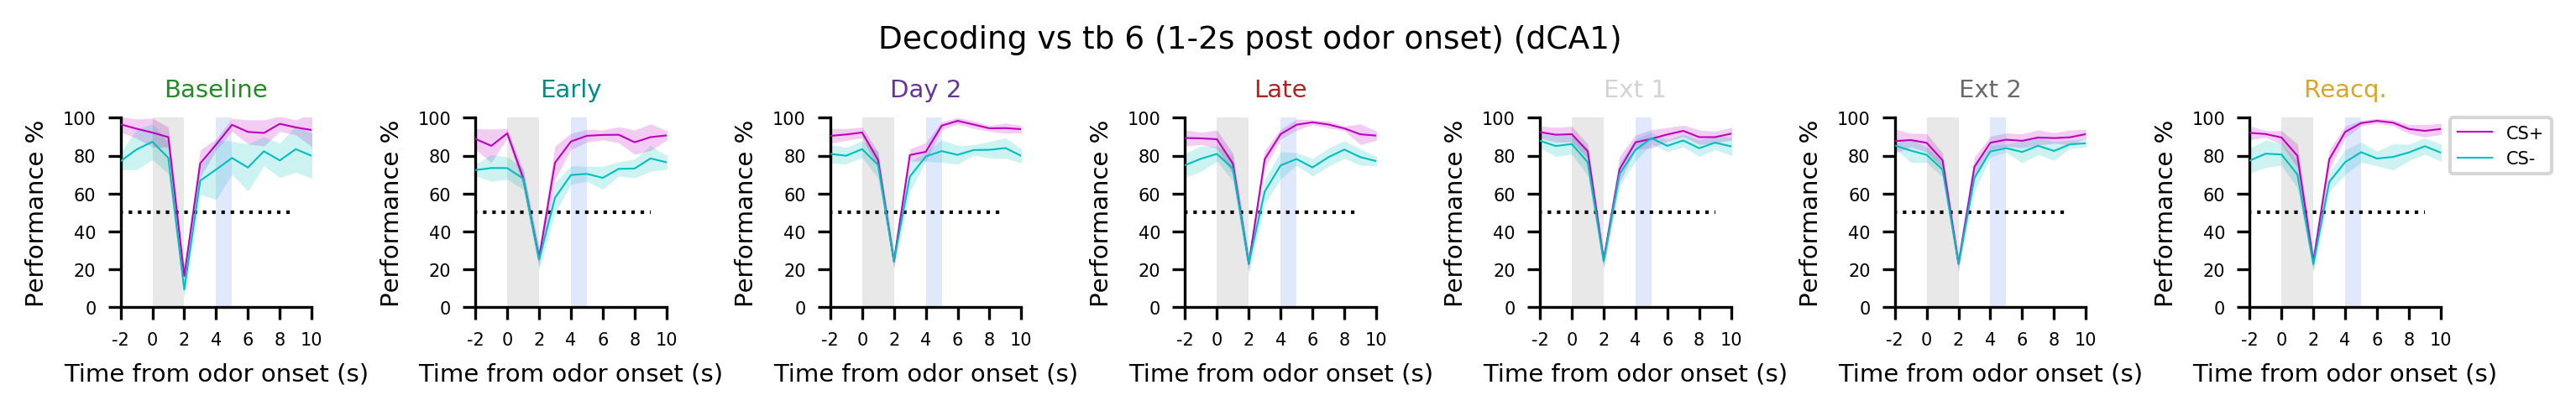

In [17]:
fig, ax = pl.subplots(1,7, figsize=(10, 1.5))

for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for r,sess in zip(range(len(sessions)),sessions):
        ax[r].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_tb_%s_%s_dhpc[sess]"%(t,comp)))*100) for t in range(16)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_dhpc[sess]"%(t,comp)))*100) for t in range(16)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s_dhpc[sess]"%(t,comp)))*100 for t in range(16)])
        ax[r].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (7):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-2, 9)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
    pt.plot_period_bar(ax[x], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0].set_title('Baseline', color=dark_co_b[0])
ax[1].set_title('Early', color = dark_co_b[1])
ax[2].set_title('Day 2', color = dark_co_b[2])
ax[3].set_title('Late', color = dark_co_b[3])
ax[4].set_title('Ext 1', color = dark_co_b[4])
ax[5].set_title('Ext 2', color = dark_co_b[5])
ax[6].set_title('Reacq.', color = dark_co_b[6])
ax[6].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs tb 6 (1-2s post odor onset) (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

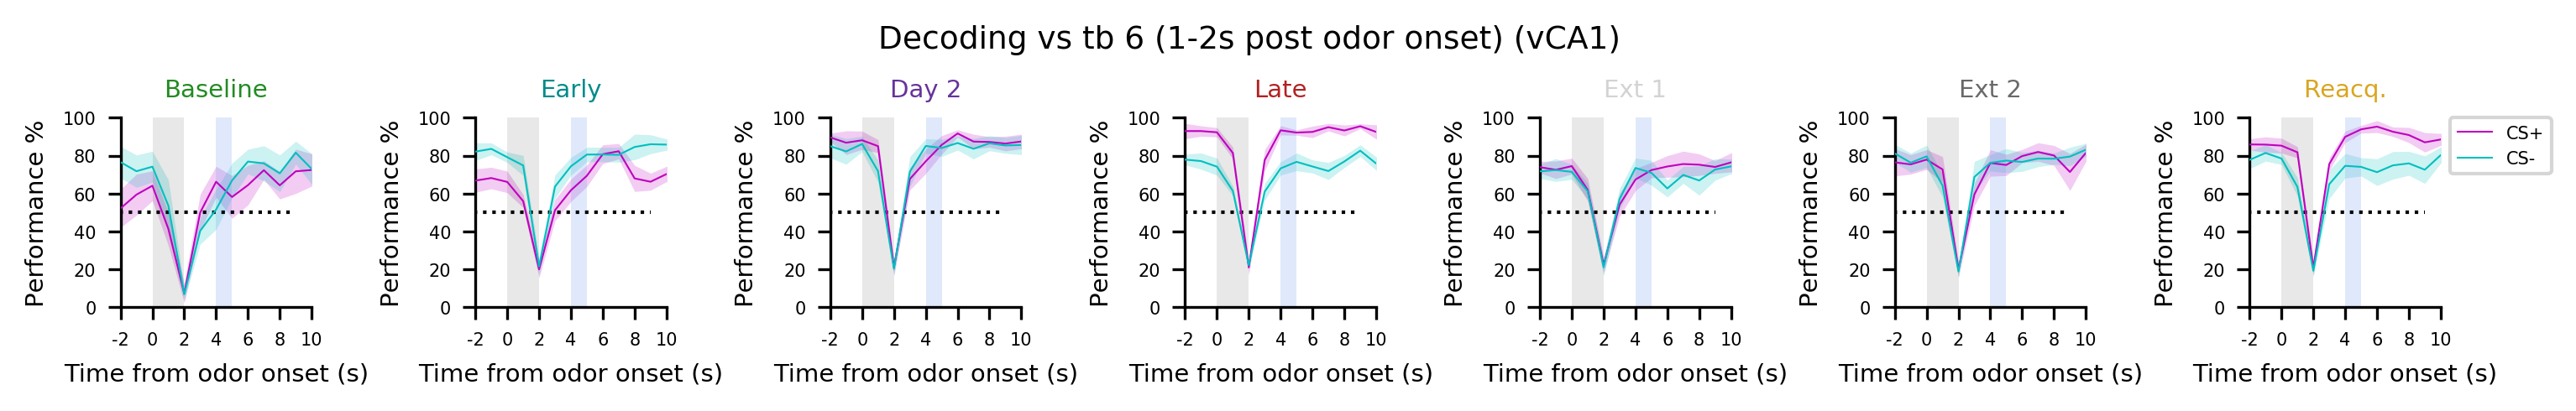

In [18]:
fig, ax = pl.subplots(1,7, figsize=(10, 1.5))

for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for r,sess in zip(range(len(sessions)),sessions):
        ax[r].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_tb_%s_%s_vhpc[sess]"%(t,comp)))*100) for t in range(16)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_vhpc[sess]"%(t,comp)))*100) for t in range(16)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s_vhpc[sess]"%(t,comp)))*100 for t in range(16)])
        ax[r].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (7):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-2, 9)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
    pt.plot_period_bar(ax[x], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0].set_title('Baseline', color=dark_co_b[0])
ax[1].set_title('Early', color = dark_co_b[1])
ax[2].set_title('Day 2', color = dark_co_b[2])
ax[3].set_title('Late', color = dark_co_b[3])
ax[4].set_title('Ext 1', color = dark_co_b[4])
ax[5].set_title('Ext 2', color = dark_co_b[5])
ax[6].set_title('Reacq.', color = dark_co_b[6])
ax[6].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs tb 6 (1-2s post odor onset) (vCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

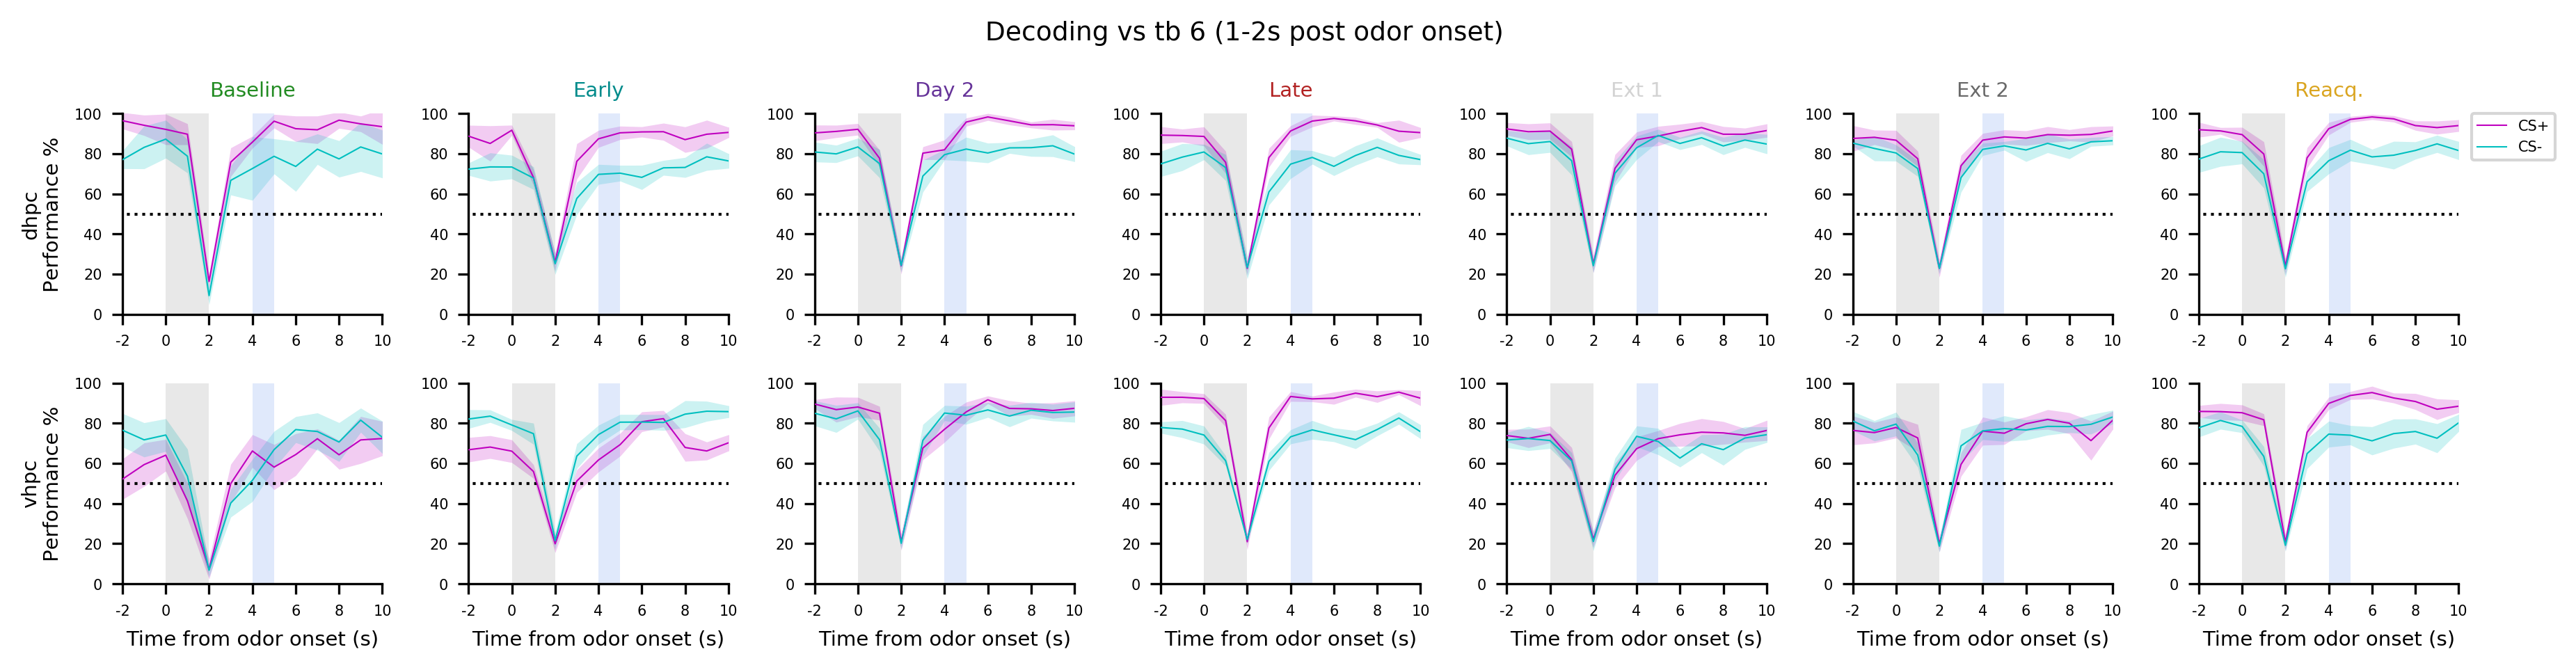

In [19]:
fig, ax = pl.subplots(2,7, figsize=(12, 3))

loops=10
for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for y,sess in zip(range(len(sessions)),sessions):
        for x,reg in zip (range(2),['dhpc','vhpc']):
            ax[x][y].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100) for t in range(16)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100) for t in range(16)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100 for t in range(16)])
            ax[x][y].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

for x,reg in zip (range(2),['dhpc','vhpc']):
    for y in range(7):
        ax[x][y].set_ylim(0, 100)
        ax[x][y].set_xlim(-2, 10)
        ax[x][y].set_xticks(np.arange(-2,11, 2))
        ax[x][y].set_xticklabels(np.arange(-2,11, 2))
        ax[x][y].hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
        ax[1][y].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel(reg+'\nPerformance %')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        ax[0][0].set_title('Baseline', color=dark_co_b[0])
        ax[0][1].set_title('Early', color = dark_co_b[1])
        ax[0][2].set_title('Day 2', color = dark_co_b[2])
        ax[0][3].set_title('Late', color = dark_co_b[3])
        ax[0][4].set_title('Ext 1', color = dark_co_b[4])
        ax[0][5].set_title('Ext 2', color = dark_co_b[5])
        ax[0][6].set_title('Reacq.', color = dark_co_b[6])
        ax[0][6].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs tb 6 (1-2s post odor onset)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../final-ish figures/%s_dv.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(2,1, figsize=(2, 2.5))

loops=10
for comp,c,la,pos in zip(['CSp','CSm'],['m','c'],['Odor 1','Odor 2'],[2,0]):
        for x,reg in zip (range(2),['dhpc','vhpc']):
            ax[x].plot([(t-4) for t in range(3,16)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)))*100) for t in range(3,16)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)))*100) for t in range(3,16)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)))*100 for t in range(3,16)])
            ax[x].fill_between([(t-4) for t in range(3,16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
            for t in range(4,12):
                add_significance_line_chance(ax[x], eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)),0.5,
                         t-4.5, t-3.5, 101+pos,color=c,thresh=.01,lines=True,stars=False,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)


for x,reg in zip (range(2),['dCA1','vCA1']):
        ax[x].set_ylim(40, 100)
        ax[x].set_xlim(-1,8)
        ax[x].set_xticks(np.arange(0,9,2))
        ax[x].set_xticklabels(np.arange(0,9,2))
        ax[x].hlines(50, -5,11, color='k', lw=.6, linestyles='dashed')
        ax[1].set_xlabel('Time from odor onset (s)')
        ax[x].set_ylabel(reg+'\nDecoding acc %')
        pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        #ax[0].set_title('Pre-training', color=dark_co_b[0])
        #ax[1].legend(bbox_to_anchor=(.55, .9), loc='upper left', borderaxespad=0.)
        ax[x].text(0.05,95,'odor1',color='mediumorchid',fontsize=6)
        ax[x].text(0.05,89,'odor2',color='darkturquoise',fontsize=6)
pl.suptitle("odor/ITI", fontsize=9, y=1.015,x=.6)

fig.tight_layout(pad=2)

fig.savefig('../final-ish figures/%s_expo_dv.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,2, figsize=(3.05, 1.4),sharey=True)

loops=10
for comp,c,la,pos in zip(['CSp','CSm'],['m','c'],['Odor 1','Odor 2'],[2,0]):
        for x,reg in zip (range(2),['vhpc','dhpc']):
            ax[x].plot([(t-4) for t in range(3,16)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)))*100) for t in range(3,16)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)))*100) for t in range(3,16)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)))*100 for t in range(3,16)])
            ax[x].fill_between([(t-4) for t in range(3,16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
            for t in range(4,12):
                add_significance_line_chance(ax[x], eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)),0.5,
                         t-4.5, t-3.5, 102+pos,color=c,thresh=.01,lines=True,stars=False,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)
report_stats_chance(baseline_scores_tb_6_CSp_dhpc['expo'][:loops],sig_func='ttest')

for x,reg,c,pos in zip (range(2),['vCA1','dCA1'],['darkorange','mediumseagreen'],[0,0.1]):
        ax[x].tick_params(axis='both',pad=1,length=2.5)
        ax[x].set_ylim(40, 100)
        ax[x].set_xlim(-1,8)
        ax[x].set_xticks(np.arange(0,9,2))
        ax[x].set_xticklabels(np.arange(0,9,2))
        ax[x].hlines(50, -5,11, color='k', lw=.6, linestyles='dashed')
        ax[x].set_xlabel('Time from odor onset (s)',labelpad=1)
        ax[0].set_ylabel('Decoding acc %',labelpad=1.5)
        pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        #ax[0].set_title('Pre-training', color=dark_co_b[0])
        #ax[1].legend(bbox_to_anchor=(.55, .9), loc='upper left', borderaxespad=0.)
        ax[x].text(0.05+pos,95.7,'odor1',color='mediumorchid',fontsize=5.5)
        ax[x].text(0.05+pos,89.3,'odor2',color='darkturquoise',fontsize=5.5)
        ax[x].set_title(reg,color=c,fontstyle='italic',fontsize=8)
pl.suptitle("odor/baseline", fontsize=9, y=1.02,x=.53)

fig.tight_layout(pad=1.5)

fig.savefig('../final-ish figures/%s_pre_dv_hor.pdf'%NOTEBOOK_NAME)

from matplotlib.patches import Patch
labels = ['odor1/\nbase','odor2/\nbase']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1,1.05))
v[sess] = np.array(np.std(baseline_scores_tb_6_CSp_vhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(-width/2-.015, np.mean(baseline_scores_tb_6_CSp_vhpc['expo'][:loops])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=v[sess])
d[sess] = np.array(np.std(baseline_scores_tb_6_CSp_dhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(width/2+.015,  np.mean(baseline_scores_tb_6_CSp_dhpc['expo'][:loops])*100, width,edgecolor='mediumorchid',color='whitesmoke',yerr=d[sess])
v[sess] = np.array(np.std(baseline_scores_tb_6_CSm_vhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(1 - width/2-.015, np.mean(baseline_scores_tb_6_CSm_vhpc['expo'][:loops])*100, width, edgecolor='darkturquoise',color='darkturquoise',yerr=v[sess])
d[sess] = np.array(np.std(baseline_scores_tb_6_CSm_dhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(1 + width/2+.015,  np.mean(baseline_scores_tb_6_CSm_dhpc['expo'][:loops])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=d[sess])
ax.hlines(50,-.5,1.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc % (SEM)',fontsize=7)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=6)
ax.legend([Patch(facecolor='whitesmoke',edgecolor='k'),Patch(facecolor='k')],['dCA1','vCA1'],loc=(.94,.8),frameon=False)
ax.tick_params(axis='x',bottom=False,pad=0)
pvs=[]
for comp,i in zip(['CSp','CSm'], range(2)):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_%s_vhpc['expo'][:loops]"%comp), eval("baseline_scores_tb_6_%s_dhpc['expo'][:loops]"%comp),
        -.2+i,0.2+i,102))
    print comp,":"
    report_stats(eval("baseline_scores_tb_6_%s_vhpc['expo'][:loops]"%comp), eval("baseline_scores_tb_6_%s_dhpc['expo'][:loops]"%comp))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('odor/m',y=1.08,x=.42,fontsize=8)

fig.savefig('../final-ish figures/%s_bars_odor_expo.pdf'%NOTEBOOK_NAME)

from matplotlib.patches import Patch
fig, ax = pl.subplots(2,1, figsize=(2.2, 2.9))

loops=10
for reg,c in zip(['dhpc','vhpc'],['mediumseagreen','darkorange']):
        for x,comp,la in zip (range(2),['CSp','CSm'],['CS+','CS-']):
            ax[x].plot([(t-4) for t in range(3,13)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)))*100) for t in range(3,13)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)))*100) for t in range(3,13)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s['expo'][:loops]"%(t,comp,reg)))*100 for t in range(3,13)])
            ax[x].fill_between([(t-4) for t in range(3,13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
            #for t in range(4,10):
            #    if eval("mannwhitU_tb_%s_%s['expo'][-1].mean()"%(t,comp)) < 0.01:
            #        if np.mean(eval("baseline_scores_tb_%s_%s_dhpc['expo'][:loops]"%(t,comp))) > np.mean(eval("baseline_scores_tb_%s_%s_vhpc['expo'][:loops]"%(t,comp))):
            #            ax[0].text(t-4.25,97,'*',fontsize=5, color='mediumseagreen')
            #        if np.mean(eval("baseline_scores_tb_%s_%s_dhpc['expo'][:loops]"%(t,comp))) < np.mean(eval("baseline_scores_tb_%s_%s_vhpc['expo'][:loops]"%(t,comp))):
            #            ax[0].text(t-4.25,97,'*',fontsize=5, color='darkorange')
            for t in range(4,13):
                add_significance_line(ax[x], eval("baseline_scores_tb_%s_%s_dhpc['expo'][:loops]"%(t,comp)), eval("baseline_scores_tb_%s_%s_vhpc['expo'][:loops]"%(t,comp)),
                         t-4.5, t-3.5, 101,color1='mediumseagreen',color2='darkorange',thresh=.01,lines=True,stars=False,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)


for x,reg,c in zip (range(2),['Odor 1','Odor 2'],['m','c']):
        ax[x].set_ylim(40, 100)
        ax[x].set_xlim(-1, 6)
        ax[x].set_xticks(np.arange(0,9, 2))
        ax[x].set_xticklabels(np.arange(0,9, 2))
        ax[x].hlines(50, -5,11, color='k', lw=.6, linestyles='dashed')
        ax[1].set_xlabel('Time from odor onset (s)')
        ax[x].set_ylabel(reg+'\nPerformance %')
        pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        #ax[0].set_title('Baseline', color=dark_co_b[0])
        ax[x].text(5.5,79,'vCA1',color='darkorange',fontsize=6.5)
        ax[x].text(5.5,86,'dCA1',color='mediumseagreen',fontsize=6.5)
        ax[x].text(0.07,95,reg,color=c,fontsize=6.5)
pl.suptitle("Decoding vs baseline", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../final-ish figures/%s_expo_dv_SplitByOdor.pdf'%NOTEBOOK_NAME)

In [55]:
sessions_to_plot = ['expo','pre','post','ext2','renew']
colors_to_plot = ('forestgreen','darkcyan','firebrick','dimgrey','goldenrod')

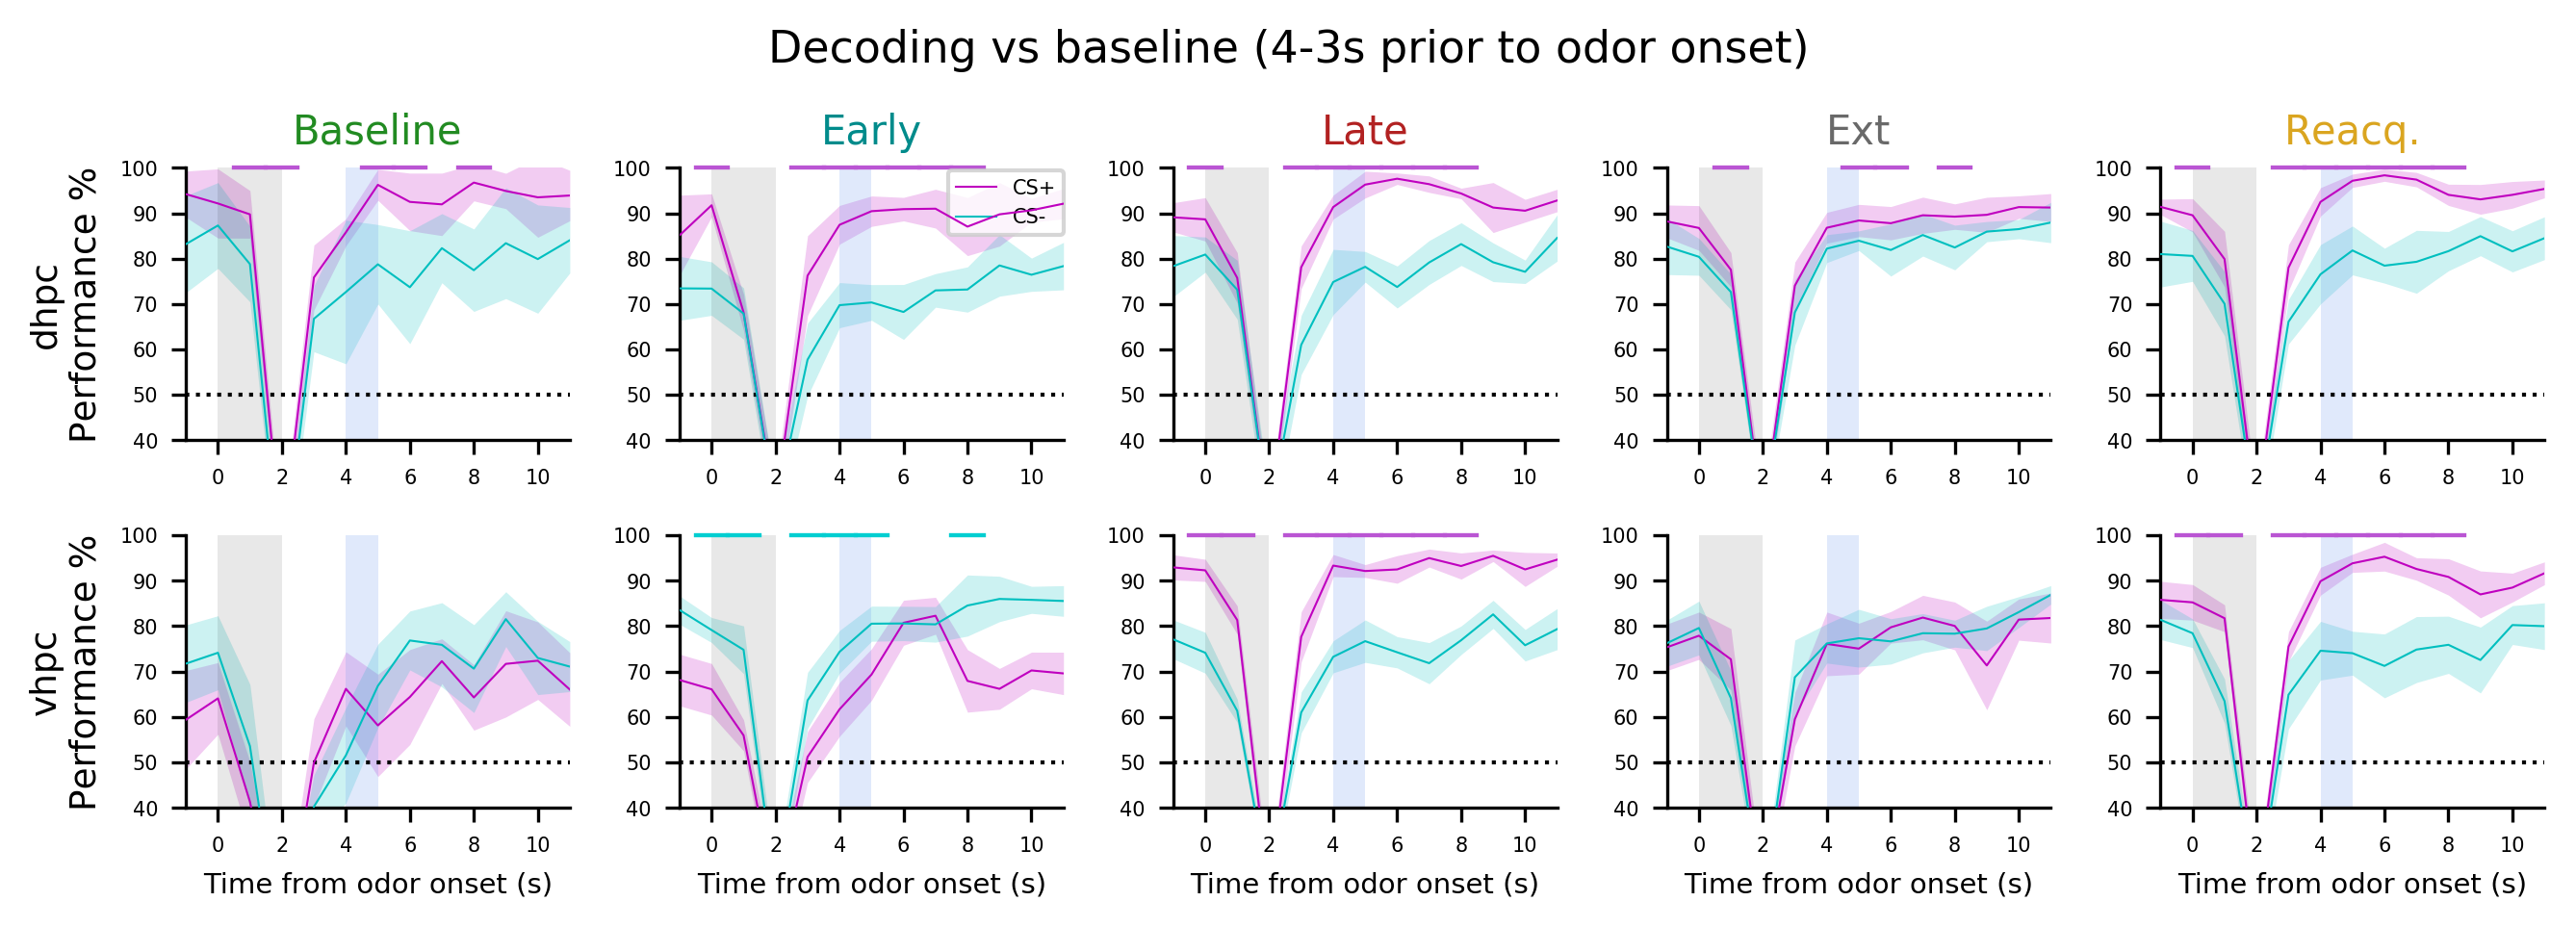

In [56]:
fig, ax = pl.subplots(2,5, figsize=(9, 3))

loops=10
for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for y,sess in zip(range(len(sessions_to_plot)),sessions_to_plot):
        for x,reg in zip (range(2),['dhpc','vhpc']):
            ax[x][y].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100) for t in range(16)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100) for t in range(16)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100 for t in range(16)])
            ax[x][y].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
            for t in range(4,13):
                add_significance_line(ax[x][y], eval("baseline_scores_tb_%s_CSp_%s[sess][:loops]"%(t,reg)), eval("baseline_scores_tb_%s_CSm_%s[sess][:loops]"%(t,reg)),
                         t-4.5, t-3.5, 100,color1='mediumorchid',color2='darkturquoise',thresh=.01,lines=True,stars=False,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)


for x,reg in zip (range(2),['dhpc','vhpc']):
    for y in range(5):
        ax[x][y].set_ylim(40, 100)
        ax[x][y].set_xlim(-1, 11)
        ax[x][y].set_xticks(np.arange(0,11, 2))
        ax[x][y].set_xticklabels(np.arange(0,11, 2))
        ax[x][y].hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
        ax[1][y].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel(reg+'\nPerformance %',fontsize=9)
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        ax[0][0].set_title('Baseline', color=dark_co_b[0],fontsize=10)
        ax[0][1].set_title('Early', color = dark_co_b[1],fontsize=10)
        ax[0][2].set_title('Late', color = dark_co_b[3],fontsize=10)
        ax[0][3].set_title('Ext', color = dark_co_b[5],fontsize=10)
        ax[0][4].set_title('Reacq.', color = dark_co_b[6],fontsize=10)
        ax[0][1].legend(bbox_to_anchor=(.7, .99), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (4-3s prior to odor onset)", fontsize=11, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../final-ish figures/%s_dv.pdf'%NOTEBOOK_NAME)

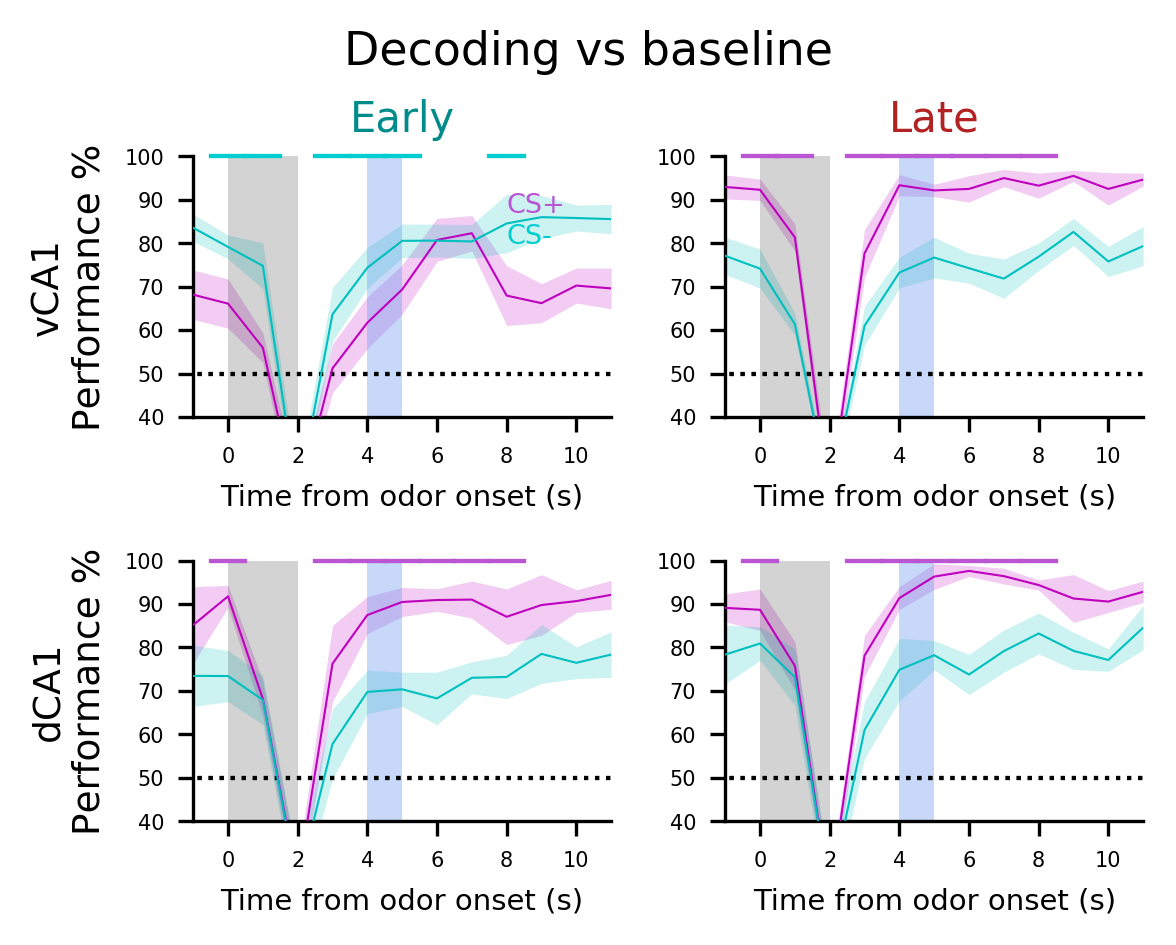

In [57]:
fig, ax = pl.subplots(2,2, figsize=(4, 3))

loops=10
for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for y,sess in zip(range(2),['pre','post']):
        for x,reg,reg_la in zip (range(2),['vhpc','dhpc'],['vCA1','dCA1']):
            ax[x][y].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100) for t in range(16)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100) for t in range(16)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100 for t in range(16)])
            for t in range(4,13):
                add_significance_line(ax[x][y], eval("baseline_scores_tb_%s_CSp_%s[sess][:loops]"%(t,reg)), eval("baseline_scores_tb_%s_CSm_%s[sess][:loops]"%(t,reg)),
                         t-4.5, t-3.5, 100,color1='mediumorchid',color2='darkturquoise',thresh=.01,lines=True,stars=False,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)
            ax[x][y].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
            ax[x][y].set_ylim(40, 100)
            ax[x][y].set_xlim(-1, 11)
            ax[x][y].set_xticks(np.arange(0,11, 2))
            ax[x][y].set_xticklabels(np.arange(0,11, 2))
            ax[x][y].hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
            ax[x][y].set_xlabel('Time from odor onset (s)')
            ax[x][0].set_ylabel(reg_la+'\nPerformance %',fontsize=9)
            pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
            pt.plot_period_bar(ax[x][y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0][0].set_title('Early', color = dark_co_b[1],fontsize=10)
ax[0][1].set_title('Late', color = dark_co_b[3],fontsize=10)
ax[0][0].text(8,87,'CS+',color='mediumorchid',fontsize=6.5)
ax[0][0].text(8,80,'CS-',color='darkturquoise',fontsize=6.5)
#ax[0][0].legend(bbox_to_anchor=(.7, .99), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline", fontsize=11, y=1.03)

fig.tight_layout(pad=2)
fig.savefig('../final-ish figures/%s_PrPo_dv.pdf'%NOTEBOOK_NAME)

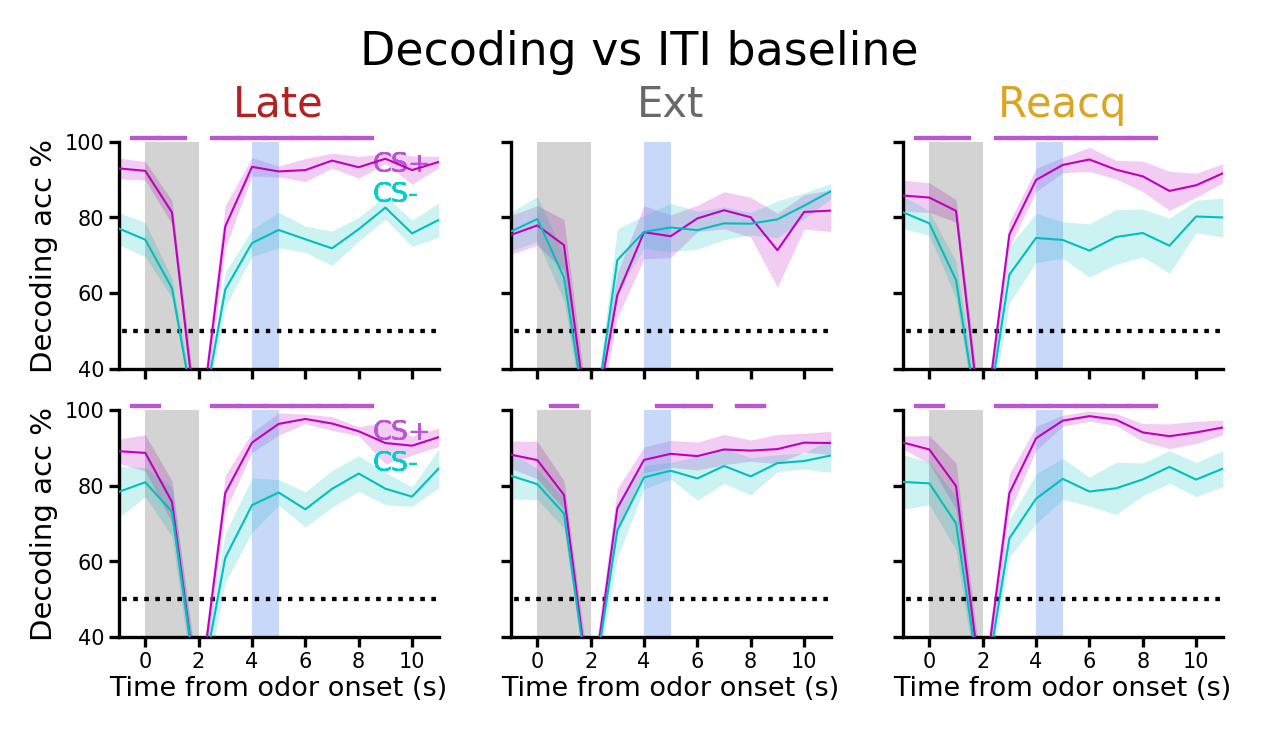

In [58]:
fig, ax = pl.subplots(2,3, figsize=(4.2, 2.2),sharex=True,sharey=True)

loops=10
for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for y,sess in zip(range(3),['post','ext2','renew']):
        for x,reg,reg_la in zip (range(2),['vhpc','dhpc'],['vCA1','dCA1']):
            ax[x][y].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100) for t in range(16)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100) for t in range(16)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s[sess][:loops]"%(t,comp,reg)))*100 for t in range(16)])
            for t in range(4,13):
                add_significance_line(ax[x][y], eval("baseline_scores_tb_%s_CSp_%s[sess][:loops]"%(t,reg)), eval("baseline_scores_tb_%s_CSm_%s[sess][:loops]"%(t,reg)),
                         t-4.5, t-3.5, 101,color1='mediumorchid',color2='darkturquoise',thresh=.01,lines=True,stars=False,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)
            ax[x][y].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
            ax[x][y].set_ylim(40, 100)
            ax[x][y].set_xlim(-1,11)
            ax[x][y].tick_params(axis='both',pad=1,length=2.5)
            ax[x][y].set_xticks(np.arange(0,11, 2))
            ax[x][y].set_xticklabels(np.arange(0,11, 2))
            ax[x][y].hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
            ax[1][y].set_xlabel('Time from odor onset (s)',fontsize=6.5,labelpad=1)
            ax[x][0].set_ylabel('Decoding acc %',fontsize=7,labelpad=1.5)
            pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
            pt.plot_period_bar(ax[x][y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
            ax[x][0].text(8.5,92,'CS+',color='mediumorchid',fontsize=6.5)
            ax[x][0].text(8.5,84,'CS-',color='darkturquoise',fontsize=6.5)
ax[0][0].set_title('Late', color = dark_co_b[3],fontsize=10)
ax[0][1].set_title('Ext', color = dark_co_b[5],fontsize=10)
ax[0][2].set_title('Reacq', color = dark_co_b[-1],fontsize=10)
#ax[0][0].legend(bbox_to_anchor=(.7, .99), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs ITI baseline", fontsize=11, y=1.05)

fig.tight_layout(pad=1)
fig.savefig('../final-ish figures/%s_PoExRe_dv.pdf'%NOTEBOOK_NAME)

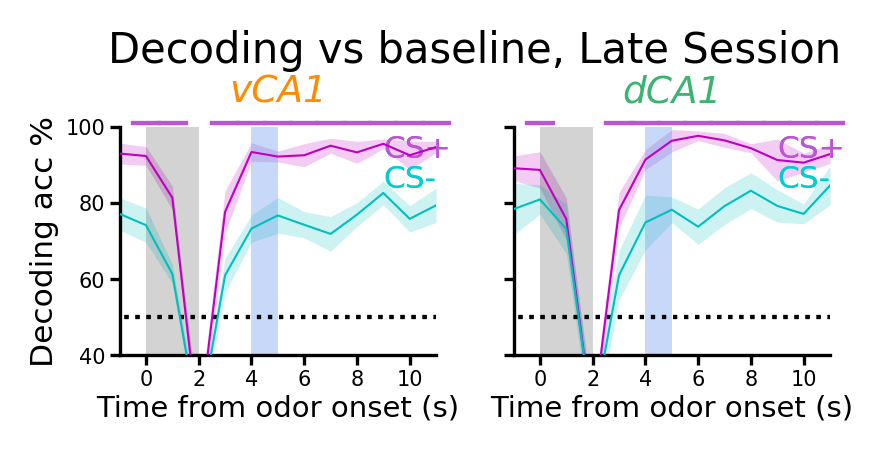

In [59]:
fig, ax = pl.subplots(1,2, figsize=(2.9, 1.3),sharey=True)

loops=10
for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for x,reg,reg_la in zip (range(2),['vhpc','dhpc'],['vCA1','dCA1']):
        ax[x].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s['post'][:loops]"%(t,comp,reg)))*100) for t in range(16)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s['post'][:loops]"%(t,comp,reg)))*100) for t in range(16)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s['post'][:loops]"%(t,comp,reg)))*100 for t in range(16)])
        for t in range(4,16):
            add_significance_line(ax[x], eval("baseline_scores_tb_%s_CSp_%s['post'][:loops]"%(t,reg)), eval("baseline_scores_tb_%s_CSm_%s['post'][:loops]"%(t,reg)),
                     t-4.5, t-3.5, 101,color1='mediumorchid',color2='darkturquoise',thresh=.01,lines=True,stars=False,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)
        ax[x].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        ax[x].set_ylim(40, 100)
        ax[x].set_xlim(-1,11)
        ax[x].tick_params(axis='both',pad=1,length=2.5)
        ax[x].set_xticks(np.arange(0,11, 2))
        ax[x].set_xticklabels(np.arange(0,11, 2))
        ax[x].hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
        ax[x].set_xlabel('Time from odor onset (s)',labelpad=1)
        ax[0].set_ylabel('Decoding acc %',fontsize=7.5,labelpad=1.5)
        pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        ax[x].text(9,92,'CS+',color='mediumorchid',fontsize=7.5)
        ax[x].text(9,84,'CS-',color='darkturquoise',fontsize=7.5)
ax[0].set_title('vCA1', color ='darkorange',fontsize=9,fontstyle='italic')
ax[1].set_title('dCA1', color ='mediumseagreen',fontsize=9,fontstyle='italic')
#ax[0].legend(bbox_to_anchor=(.7, .99), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline, Late Session", fontsize=10, y=1.06,x=.535)

fig.tight_layout(pad=1)
fig.savefig('../final-ish figures/%s_Po_dv.pdf'%NOTEBOOK_NAME)

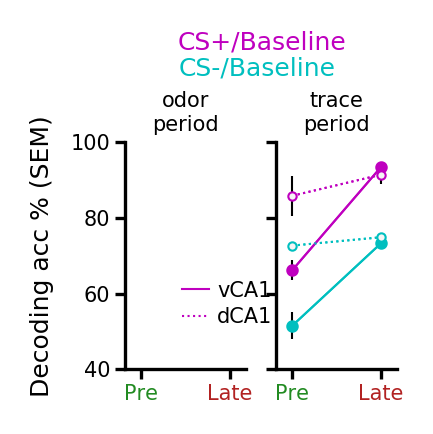

In [60]:
fig,ax = pl.subplots(1,2,figsize=(1.4,1.2),sharex=True,sharey=True)
v={}
d={}
loops=10
expectations = 'expo','post'

# Add connecting lines            
for ex,c,z in zip(expectations,(('powderblue','midnightblue')),(.2,1.3)):
    for tb,tb_la,x in zip((6,8),('odor','trace'),(range(2))):
            ax[x].plot([p for p in (.2,1.3)],
                       [np.mean(eval("baseline_scores_tb_%s_CSp_vhpc[ex][:loops]"%(tb)))*100 for ex in expectations],
                       color='m',label='vCA1')
            ax[x].plot([p for p in (.2,1.3)],
                       [np.mean(eval("baseline_scores_tb_%s_CSp_dhpc[ex][:loops]"%(tb)))*100 for ex in expectations],
                       color='m',label='dCA1',linestyle=":")
            ax[x].plot([p for p in (.2,1.3)],
                       [np.mean(eval("baseline_scores_tb_%s_CSm_vhpc[ex][:loops]"%(tb)))*100 for ex in expectations],
                       color='c',label='vCA1')
            ax[x].plot([p for p in (.2,1.3)],
                       [np.mean(eval("baseline_scores_tb_%s_CSm_dhpc[ex][:loops]"%(tb)))*100 for ex in expectations],
                       color='c',label='dCA1',linestyle=":")
            
for ex,c,z in zip(expectations,(('powderblue','midnightblue')),(.2,1.3)):
    for tb,tb_la,x in zip((6,8),('odor','trace'),(range(2))):
            v[ex+tb_la] = np.array(np.std(eval("baseline_scores_tb_%s_CSp_vhpc[ex][:loops]"%(tb)))*100/np.sqrt(loops-1))
            ax[x].plot(z, (np.mean(eval("baseline_scores_tb_%s_CSp_vhpc[ex][:loops]"%(tb)))*100), 'o', color='m',markersize=2)
            ax[x].errorbar(z, (np.mean(eval("baseline_scores_tb_%s_CSp_vhpc[ex][:loops]"%(tb)))*100),yerr=v[ex+tb_la],color='k')  
            d[ex+tb_la] = np.array(np.std(eval("baseline_scores_tb_%s_CSp_dhpc[ex][:loops]"%(tb)))*100/np.sqrt(loops-1))
            ax[x].plot(z, (np.mean(eval("baseline_scores_tb_%s_CSp_dhpc[ex][:loops]"%(tb)))*100), 'o', 
                       color='whitesmoke',mec='m',markersize=2,mew=.5)
            ax[x].errorbar(z, (np.mean(eval("baseline_scores_tb_%s_CSp_dhpc[ex][:loops]"%(tb)))*100),yerr=d[ex+tb_la],color='k')
            
            v[ex+tb_la] = np.array(np.std(eval("baseline_scores_tb_%s_CSm_vhpc[ex][:loops]"%(tb)))*100/np.sqrt(loops-1))
            ax[x].plot(z, (np.mean(eval("baseline_scores_tb_%s_CSm_vhpc[ex][:loops]"%(tb)))*100), 'o', color='c',markersize=2)
            ax[x].errorbar(z, (np.mean(eval("baseline_scores_tb_%s_CSm_vhpc[ex][:loops]"%(tb)))*100),yerr=v[ex+tb_la],color='k')  
            d[ex+tb_la] = np.array(np.std(eval("baseline_scores_tb_%s_CSm_dhpc[ex][:loops]"%(tb)))*100/np.sqrt(loops-1))
            ax[x].plot(z, (np.mean(eval("baseline_scores_tb_%s_CSm_dhpc[ex][:loops]"%(tb)))*100), 'o', 
                       color='whitesmoke',mec='c',markersize=2,mew=.5)
            ax[x].errorbar(z, (np.mean(eval("baseline_scores_tb_%s_CSp_dhpc[ex][:loops]"%(tb)))*100),yerr=d[ex+tb_la],color='k') 
            

            ax[x].tick_params(axis='both',pad=1,length=2.5)
            ax[0].set_ylabel('Decoding acc % (SEM)',fontsize=6)
            ax[x].set_ylim(40,100)
            #ax[x].hlines(50, -.5,2.5, color='k', lw=1, linestyles='dotted')
            ax[x].set_title(tb_la+"\nperiod",y=.94,fontsize=5)
            ax[x].set_xlim(0,1.5)
            ax[x].set_xticks((.2,1.3))
            ax[x].set_xticklabels(['Pre','Late'])
            [t.set_color(i) for (i,t) in zip([dark_co[0],dark_co[2]],ax[x].xaxis.get_ticklabels())]
ax[0].legend(labels=['vCA1','dCA1'],frameon=False, loc=(.4,.15),labelspacing=.3,handletextpad=0.4,handlelength=1.3)
#pl.suptitle('Decoding vs Baseline',fontsize=7,x=.55,y=1.05)
ax[0].text(.65,124.5,'CS+/Baseline',fontsize=6,color='m')
ax[0].text(.67,117.5,'CS-/Baseline',fontsize=6,color='c')


fig.tight_layout(pad=1.2)

fig.savefig('../final-ish figures/%s_gmin_ExPo_dots.pdf'%NOTEBOOK_NAME)

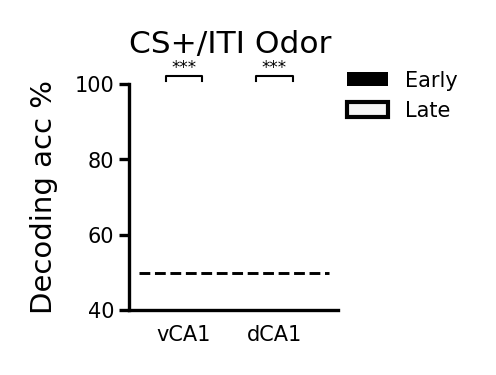

In [61]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.9,1))
for sess,c,i in zip(['expo','post'],[dark_co[0],dark_co[2]],[-width/2-.03,+width/2+.03]):
    v[sess] = np.array(np.std(baseline_scores_tb_6_CSp_vhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(0 + i, np.mean(baseline_scores_tb_6_CSp_vhpc[sess][:loops])*100, width, color=c, edgecolor=c,yerr=v[sess])
    d[sess] = np.array(np.std(baseline_scores_tb_6_CSp_dhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(1.1 + i,  np.mean(baseline_scores_tb_6_CSp_dhpc[sess][:loops])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,1.6, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etcsess
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['Early','Late'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['expo','post'], range(2)):
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_vhpc['expo'][:loops], baseline_scores_tb_6_CSp_vhpc['post'][:loops],
        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS+/ITI Odor',y=1.06,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_odor_ExPo_CSp.pdf'%NOTEBOOK_NAME)

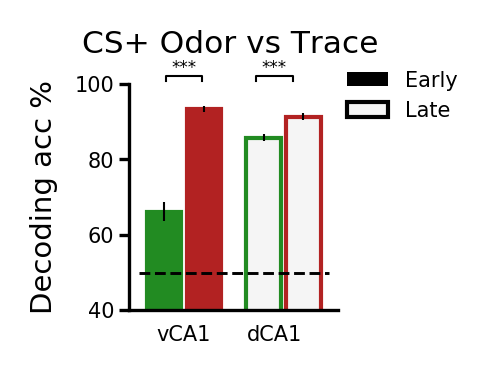

In [62]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.9,1))
for sess,c,i in zip(['expo','post'],[dark_co[0],dark_co[2]],[-width/2-.03,+width/2+.03]):
    v[sess] = np.array(np.std(baseline_scores_tb_8_CSp_vhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(0 + i, np.mean(baseline_scores_tb_8_CSp_vhpc[sess][:loops])*100, width, color=c, edgecolor=c,yerr=v[sess])
    d[sess] = np.array(np.std(baseline_scores_tb_8_CSp_dhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(1.1 + i,  np.mean(baseline_scores_tb_8_CSp_dhpc[sess][:loops])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,1.6, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etcsess
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['Early','Late'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['expo','post'], range(2)):
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_vhpc['expo'][:loops], baseline_scores_tb_8_CSp_vhpc['post'][:loops],
        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS+ Odor vs Trace',y=1.06,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_tr_ExPo_CSp.pdf'%NOTEBOOK_NAME)

NameError: name 'mean_scores_gmin_tb_6_vhpc' is not defined

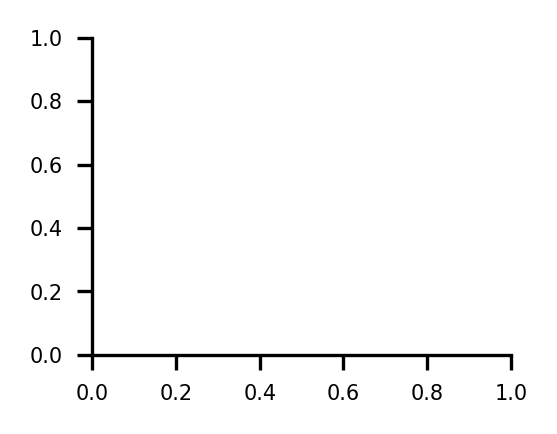

In [63]:
fig, ax = pl.subplots(figsize=(1.8,1.4))
for sess,c,i,lab in zip(['pre','post','ext2','renew'],to_plot,range(4),['Early','Late','Ext','Reinstate']):
    v[sess] = np.array(np.std(mean_scores_gmin_tb_6_vhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i, np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100, width, color=dark_co[c],edgecolor=dark_co[c],yerr=v[sess],label=lab)
    d[sess] = np.array(np.std(mean_scores_gmin_tb_6_dhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i + 4.5,  np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100, width,color='whitesmoke', edgecolor=dark_co[c],yerr=d[sess])
ax.hlines(50,-.5,8, color='k', lw=.7, linestyles='dashed')

ax.set_ylabel('Decoding acc % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([1.5,6])
ax.set_xticklabels(['vCA1','dCA1'])
ax.legend(loc=(1,.5),frameon=False)
#ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
sessi = ['pre','post','ext2','renew']
for i in range(3):
    pvs.append(add_significance(ax, mean_scores_gmin_tb_6_vhpc[sessi[i]][:loops], mean_scores_gmin_tb_6_vhpc[sessi[i+1]][:loops],
        i+.05,i+.95,95,mcc=3))
    pvs.append(add_significance(ax, mean_scores_gmin_tb_6_dhpc[sessi[i]][:loops], mean_scores_gmin_tb_6_dhpc[sessi[i+1]][:loops],
        i+4.55,i+5.45,95,mcc=3))
for i in range(2):
    pvs.append(add_significance(ax, mean_scores_gmin_tb_6_vhpc[sessi[i]][:loops], mean_scores_gmin_tb_6_vhpc[sessi[i+2]][:loops],
        i+.05,i+1.95,99+i*5,mcc=3))
    pvs.append(add_significance(ax, mean_scores_gmin_tb_6_dhpc[sessi[i]][:loops], mean_scores_gmin_tb_6_dhpc[sessi[i+2]][:loops],
        i+4.55,i+6.45,99+i*5,mcc=3))
    
pvs.append(add_significance(ax, mean_scores_gmin_tb_6_vhpc[sessi[0]][:loops], mean_scores_gmin_tb_6_vhpc[sessi[3]][:loops],
        .05,2.95,108,mcc=3))
pvs.append(add_significance(ax, mean_scores_gmin_tb_6_dhpc[sessi[0]][:loops], mean_scores_gmin_tb_6_dhpc[sessi[3]][:loops],
        4.55,7.55,108,mcc=3))

vCA1 pre vs post U = 44.0 p = 2.03103453607 r = -0.101418510567
None
dCA1 pre vs post U = 75.0 p = 0.189968039706 r = 0.422577127364
None
vCA1 post vs ext2 U = 58.0 p = 1.71094588793 r = 0.135224680757
None
dCA1 post vs ext2 U = 44.5 p = 2.11510154281 r = -0.0929669680201
None
vCA1 ext2 vs renew U = 44.0 p = 2.03068936723 r = -0.101418510567
None
dCA1 ext2 vs renew U = 42.0 p = 1.70919936082 r = -0.135224680757
None
vCA1 pre vs ext2 U = 49.5 p = 3.0 r = -0.00845154254729
None
dCA1 pre vs ext2 U = 64.5 p = 0.865938052678 r = 0.245094733871
None
vCA1 post vs renew U = 54.5 p = 2.2858032095 r = 0.0760638829256
None
dCA1 post vs renew U = 37.5 p = 1.09195558461 r = -0.211288563682
None
vCA1 pre vs renew U = 45.5 p = 2.28606443025 r = -0.0760638829256
None
dCA1 pre vs renew U = 57.5 p = 1.7859427736 r = 0.126773138209
None


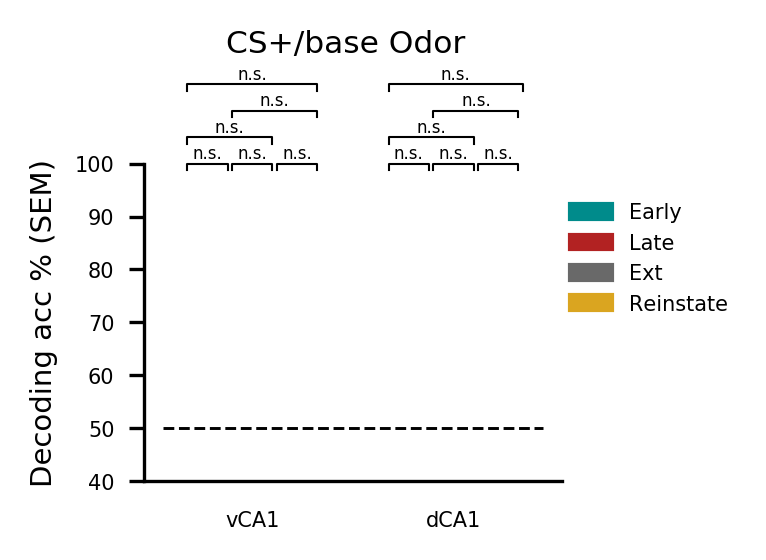

In [64]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(1.8,1.4))
for sess,c,i,lab in zip(['pre','post','ext2','renew'],[dark_co[1],dark_co[2],dark_co[-2],dark_co[-1]],range(4),['Early','Late','Ext','Reinstate']):
    v[sess] = np.array(np.std(baseline_scores_tb_6_CSp_vhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i, np.mean(baseline_scores_tb_6_CSp_vhpc[sess][:loops])*100, width, color=c, edgecolor=c,yerr=v[sess],label=lab)
    d[sess] = np.array(np.std(baseline_scores_tb_6_CSp_dhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i+4.5, np.mean(baseline_scores_tb_6_CSp_dhpc[sess][:loops])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,8, color='k', lw=.7, linestyles='dashed')

ax.set_ylabel('Decoding acc % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([1.5,6])
ax.set_xticklabels(['vCA1','dCA1'])
ax.legend(loc=(1,.5),frameon=False)
#ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)

pvs=[]
sessi = ['pre','post','ext2','renew']
for i in range(3):
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_vhpc[sessi[i]][:loops], baseline_scores_tb_6_CSp_vhpc[sessi[i+1]][:loops],
        i+.05,i+.95,100,mcc=3))
    print 'vCA1',sessi[i],'vs',sessi[i+1],report_stats(baseline_scores_tb_6_CSp_vhpc[sessi[i]][:loops], baseline_scores_tb_6_CSp_vhpc[sessi[i+1]][:loops],mcc=3)
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_dhpc[sessi[i]][:loops], baseline_scores_tb_6_CSp_dhpc[sessi[i+1]][:loops],
        i+4.55,i+5.45,100,mcc=3))
    print 'dCA1',sessi[i],'vs',sessi[i+1],report_stats(baseline_scores_tb_6_CSp_dhpc[sessi[i]][:loops], baseline_scores_tb_6_CSp_dhpc[sessi[i+1]][:loops],mcc=3)
for i in range(2):
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_vhpc[sessi[i]][:loops], baseline_scores_tb_6_CSp_vhpc[sessi[i+2]][:loops],
        i+.05,i+1.95,105+i*5,mcc=3))
    print 'vCA1',sessi[i],'vs',sessi[i+2],report_stats(baseline_scores_tb_6_CSp_vhpc[sessi[i]][:loops], baseline_scores_tb_6_CSp_vhpc[sessi[i+2]][:loops],mcc=3)
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_dhpc[sessi[i]][:loops], baseline_scores_tb_6_CSp_dhpc[sessi[i+2]][:loops],
        i+4.55,i+6.45,105+i*5,mcc=3))   
    print 'dCA1',sessi[i],'vs',sessi[i+2],report_stats(baseline_scores_tb_6_CSp_dhpc[sessi[i]][:loops], baseline_scores_tb_6_CSp_dhpc[sessi[i+2]][:loops],mcc=3)
pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_vhpc[sessi[0]][:loops], baseline_scores_tb_6_CSp_vhpc[sessi[3]][:loops],
        .05,2.95,115,mcc=3))
print 'vCA1',sessi[0],'vs',sessi[3],report_stats(baseline_scores_tb_6_CSp_vhpc[sessi[0]][:loops], baseline_scores_tb_6_CSp_vhpc[sessi[3]][:loops],mcc=3)
pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_dhpc[sessi[0]][:loops], baseline_scores_tb_6_CSp_dhpc[sessi[3]][:loops],
        4.55,7.55,115,mcc=3))
print 'dCA1',sessi[0],'vs',sessi[3],report_stats(baseline_scores_tb_6_CSp_dhpc[sessi[0]][:loops], baseline_scores_tb_6_CSp_dhpc[sessi[3]][:loops],mcc=3)

#for sess,i in zip(['expo','post'], range(2)):
#    pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_vhpc['expo'][:loops], baseline_scores_tb_6_CSp_vhpc['post'][:loops],
#        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS+/base Odor',y=1.2,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_CS_PrPoExRe_CSp.pdf'%NOTEBOOK_NAME)

vCA1 pre vs post U = 0.0 p = 0.000515025261514 r = -0.845154254729
None
dCA1 pre vs post U = 22.0 p = 0.111829389615 r = -0.473286382648
None
vCA1 post vs ext2 U = 100.0 p = 0.000517961990647 r = 0.845154254729
None
dCA1 post vs ext2 U = 86.5 p = 0.0192044997364 r = 0.616962605952
None
vCA1 ext2 vs renew U = 1.5 p = 0.000828552216955 r = -0.819799627087
None
dCA1 ext2 vs renew U = 12.5 p = 0.015326181175 r = -0.633865691046
None
vCA1 pre vs ext2 U = 7.5 p = 0.00440475707206 r = -0.718381116519
None
dCA1 pre vs ext2 U = 56.0 p = 2.03103453607 r = 0.101418510567
None
vCA1 post vs renew U = 81.0 p = 0.0612346234214 r = 0.523995637932
None
dCA1 post vs renew U = 42.5 p = 1.78636078674 r = -0.126773138209
None
vCA1 pre vs renew U = 0.0 p = 0.000529833035007 r = -0.845154254729
None
dCA1 pre vs renew U = 15.5 p = 0.0301562878173 r = -0.583156435763
None


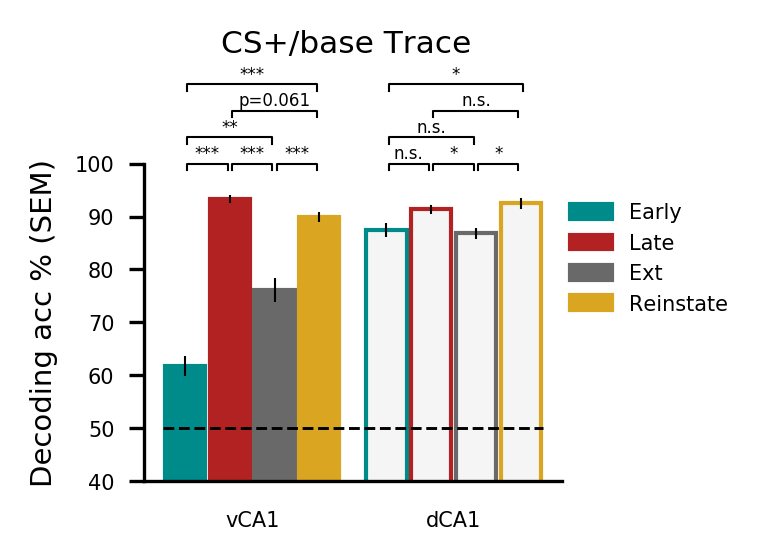

In [65]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(1.8,1.4))
for sess,c,i,lab in zip(['pre','post','ext2','renew'],[dark_co[1],dark_co[2],dark_co[-2],dark_co[-1]],range(4),['Early','Late','Ext','Reinstate']):
    v[sess] = np.array(np.std(baseline_scores_tb_8_CSp_vhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i, np.mean(baseline_scores_tb_8_CSp_vhpc[sess][:loops])*100, width, color=c, edgecolor=c,yerr=v[sess],label=lab)
    d[sess] = np.array(np.std(baseline_scores_tb_8_CSp_dhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i+4.5, np.mean(baseline_scores_tb_8_CSp_dhpc[sess][:loops])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,8, color='k', lw=.7, linestyles='dashed')

ax.set_ylabel('Decoding acc % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([1.5,6])
ax.set_xticklabels(['vCA1','dCA1'])
ax.legend(loc=(1,.5),frameon=False)
#ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)

pvs=[]
sessi = ['pre','post','ext2','renew']
for i in range(3):
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_vhpc[sessi[i]][:loops], baseline_scores_tb_8_CSp_vhpc[sessi[i+1]][:loops],
        i+.05,i+.95,100,mcc=3))
    print 'vCA1',sessi[i],'vs',sessi[i+1],report_stats(baseline_scores_tb_8_CSp_vhpc[sessi[i]][:loops], baseline_scores_tb_8_CSp_vhpc[sessi[i+1]][:loops],mcc=3)
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_dhpc[sessi[i]][:loops], baseline_scores_tb_8_CSp_dhpc[sessi[i+1]][:loops],
        i+4.55,i+5.45,100,mcc=3))
    print 'dCA1',sessi[i],'vs',sessi[i+1],report_stats(baseline_scores_tb_8_CSp_dhpc[sessi[i]][:loops], baseline_scores_tb_8_CSp_dhpc[sessi[i+1]][:loops],mcc=3)
for i in range(2):
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_vhpc[sessi[i]][:loops], baseline_scores_tb_8_CSp_vhpc[sessi[i+2]][:loops],
        i+.05,i+1.95,105+i*5,mcc=3))
    print 'vCA1',sessi[i],'vs',sessi[i+2],report_stats(baseline_scores_tb_8_CSp_vhpc[sessi[i]][:loops], baseline_scores_tb_8_CSp_vhpc[sessi[i+2]][:loops],mcc=3)
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_dhpc[sessi[i]][:loops], baseline_scores_tb_8_CSp_dhpc[sessi[i+2]][:loops],
        i+4.55,i+6.45,105+i*5,mcc=3))   
    print 'dCA1',sessi[i],'vs',sessi[i+2],report_stats(baseline_scores_tb_8_CSp_dhpc[sessi[i]][:loops], baseline_scores_tb_8_CSp_dhpc[sessi[i+2]][:loops],mcc=3)
pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_vhpc[sessi[0]][:loops], baseline_scores_tb_8_CSp_vhpc[sessi[3]][:loops],
        .05,2.95,115,mcc=3))
print 'vCA1',sessi[0],'vs',sessi[3],report_stats(baseline_scores_tb_8_CSp_vhpc[sessi[0]][:loops], baseline_scores_tb_8_CSp_vhpc[sessi[3]][:loops],mcc=3)
pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_dhpc[sessi[0]][:loops], baseline_scores_tb_8_CSp_dhpc[sessi[3]][:loops],
        4.55,7.55,115,mcc=3))
print 'dCA1',sessi[0],'vs',sessi[3],report_stats(baseline_scores_tb_8_CSp_dhpc[sessi[0]][:loops], baseline_scores_tb_8_CSp_dhpc[sessi[3]][:loops],mcc=3)

#for sess,i in zip(['expo','post'], range(2)):
#    pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_vhpc['expo'][:loops], baseline_scores_tb_8_CSp_vhpc['post'][:loops],
#        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS+/base Trace',y=1.2,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_tr_PrPoExRe_CSp.pdf'%NOTEBOOK_NAME)

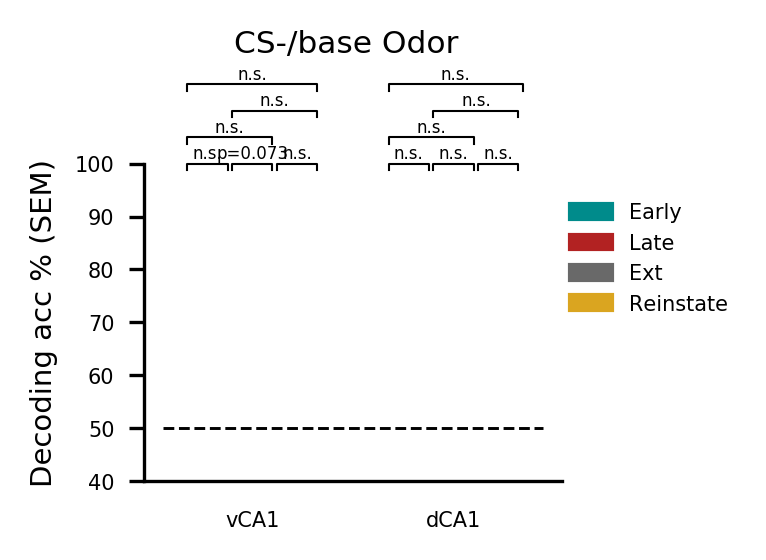

In [66]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(1.8,1.4))
for sess,c,i,lab in zip(['pre','post','ext2','renew'],[dark_co[1],dark_co[2],dark_co[-2],dark_co[-1]],range(4),['Early','Late','Ext','Reinstate']):
    v[sess] = np.array(np.std(baseline_scores_tb_6_CSm_vhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i, np.mean(baseline_scores_tb_6_CSm_vhpc[sess][:loops])*100, width, color=c, edgecolor=c,yerr=v[sess],label=lab)
    d[sess] = np.array(np.std(baseline_scores_tb_6_CSm_dhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i+4.5, np.mean(baseline_scores_tb_6_CSm_dhpc[sess][:loops])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,8, color='k', lw=.7, linestyles='dashed')

ax.set_ylabel('Decoding acc % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([1.5,6])
ax.set_xticklabels(['vCA1','dCA1'])
ax.legend(loc=(1,.5),frameon=False)
#ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)

pvs=[]
sessi = ['pre','post','ext2','renew']
for i in range(3):
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSm_vhpc[sessi[i]][:loops], baseline_scores_tb_6_CSm_vhpc[sessi[i+1]][:loops],
        i+.05,i+.95,100,mcc=3))
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSm_dhpc[sessi[i]][:loops], baseline_scores_tb_6_CSm_dhpc[sessi[i+1]][:loops],
        i+4.55,i+5.45,100,mcc=3))
for i in range(2):
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSm_vhpc[sessi[i]][:loops], baseline_scores_tb_6_CSm_vhpc[sessi[i+2]][:loops],
        i+.05,i+1.95,105+i*5,mcc=3))
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSm_dhpc[sessi[i]][:loops], baseline_scores_tb_6_CSm_dhpc[sessi[i+2]][:loops],
        i+4.55,i+6.45,105+i*5,mcc=3))   
pvs.append(add_significance(ax, baseline_scores_tb_6_CSm_vhpc[sessi[0]][:loops], baseline_scores_tb_6_CSm_vhpc[sessi[3]][:loops],
        .05,2.95,115,mcc=3))
pvs.append(add_significance(ax, baseline_scores_tb_6_CSm_dhpc[sessi[0]][:loops], baseline_scores_tb_6_CSm_dhpc[sessi[3]][:loops],
        4.55,7.55,115,mcc=3))

#for sess,i in zip(['expo','post'], range(2)):
#    pvs.append(add_significance(ax, baseline_scores_tb_6_CSm_vhpc['expo'][:loops], baseline_scores_tb_6_CSm_vhpc['post'][:loops],
#        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS-/base Odor',y=1.2,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_CS_PrPoExRe_CSm.pdf'%NOTEBOOK_NAME)

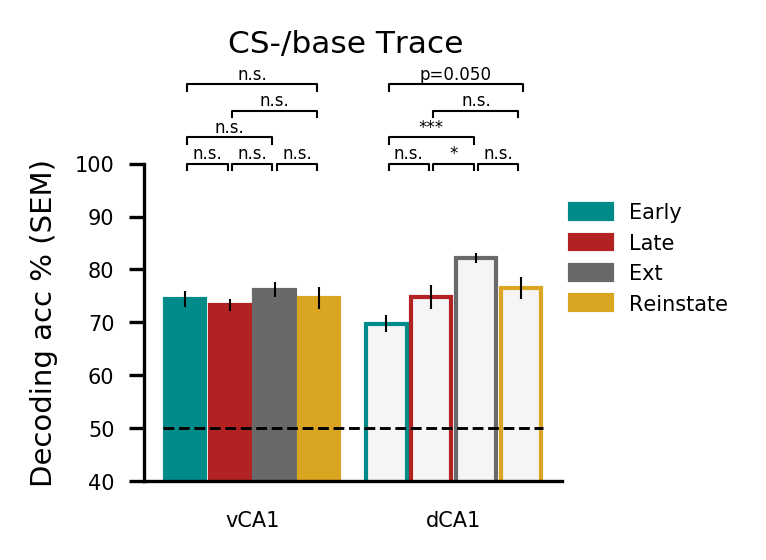

In [67]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(1.8,1.4))
for sess,c,i,lab in zip(['pre','post','ext2','renew'],[dark_co[1],dark_co[2],dark_co[-2],dark_co[-1]],range(4),['Early','Late','Ext','Reinstate']):
    v[sess] = np.array(np.std(baseline_scores_tb_8_CSm_vhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i, np.mean(baseline_scores_tb_8_CSm_vhpc[sess][:loops])*100, width, color=c, edgecolor=c,yerr=v[sess],label=lab)
    d[sess] = np.array(np.std(baseline_scores_tb_8_CSm_dhpc[sess][:loops])/np.sqrt(loops)*100)
    ax.bar(i+4.5, np.mean(baseline_scores_tb_8_CSm_dhpc[sess][:loops])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,8, color='k', lw=.7, linestyles='dashed')

ax.set_ylabel('Decoding acc % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([1.5,6])
ax.set_xticklabels(['vCA1','dCA1'])
ax.legend(loc=(1,.5),frameon=False)
#ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)

pvs=[]
sessi = ['pre','post','ext2','renew']
for i in range(3):
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSm_vhpc[sessi[i]][:loops], baseline_scores_tb_8_CSm_vhpc[sessi[i+1]][:loops],
        i+.05,i+.95,100,mcc=3))
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSm_dhpc[sessi[i]][:loops], baseline_scores_tb_8_CSm_dhpc[sessi[i+1]][:loops],
        i+4.55,i+5.45,100,mcc=3))
for i in range(2):
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSm_vhpc[sessi[i]][:loops], baseline_scores_tb_8_CSm_vhpc[sessi[i+2]][:loops],
        i+.05,i+1.95,105+i*5,mcc=3))
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSm_dhpc[sessi[i]][:loops], baseline_scores_tb_8_CSm_dhpc[sessi[i+2]][:loops],
        i+4.55,i+6.45,105+i*5,mcc=3))   
pvs.append(add_significance(ax, baseline_scores_tb_8_CSm_vhpc[sessi[0]][:loops], baseline_scores_tb_8_CSm_vhpc[sessi[3]][:loops],
        .05,2.95,115,mcc=3))
pvs.append(add_significance(ax, baseline_scores_tb_8_CSm_dhpc[sessi[0]][:loops], baseline_scores_tb_8_CSm_dhpc[sessi[3]][:loops],
        4.55,7.55,115,mcc=3))

#for sess,i in zip(['expo','post'], range(2)):
#    pvs.append(add_significance(ax, baseline_scores_tb_8_CSm_vhpc['expo'][:loops], baseline_scores_tb_8_CSm_vhpc['post'][:loops],
#        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS-/base Trace',y=1.2,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_tr_PrPoExRe_CSm.pdf'%NOTEBOOK_NAME)

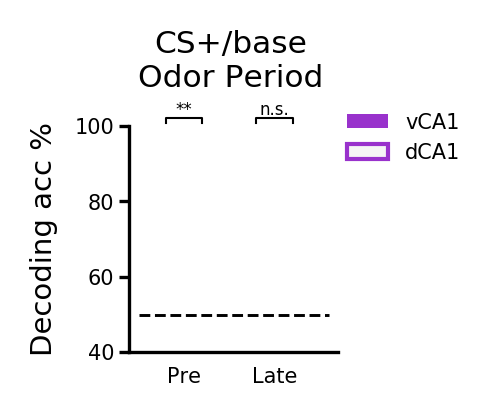

In [68]:
from matplotlib.patches import Patch
labels = ['Pre','Late']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.9,1))
for reg,c,i in zip(['vhpc','dhpc'],['darkorchid','whitesmoke'],[-width/2-.03,+width/2+.03]):
    v[reg] = np.array(np.std(eval("baseline_scores_tb_6_CSp_%s['expo']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(0+i, np.mean(eval("baseline_scores_tb_6_CSp_%s['expo']"%(reg))[:loops])*100, width, color=c,edgecolor='darkorchid',yerr=v[reg])
    d[reg] = np.array(np.std(eval("baseline_scores_tb_6_CSp_%s['post']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(1.1+i,  np.mean(eval("baseline_scores_tb_6_CSp_%s['post']"%(reg))[:loops])*100, width,color=c, edgecolor='darkorchid',yerr=d[reg])
ax.hlines(50,-.5,1.6, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='whitesmoke',edgecolor='darkorchid')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['expo','post'], range(2)):
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_vhpc[sess][:loops], baseline_scores_tb_6_CSp_dhpc[sess][:loops],
        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS+/base\nOdor Period',y=1.2,fontsize=7.5)

#fig.savefig('../final-ish figures/%s_gmin_bars_odor_ExPo_CSp_b.pdf'%NOTEBOOK_NAME)

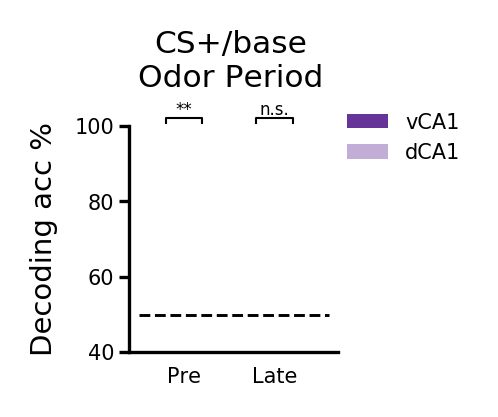

In [69]:
from matplotlib.patches import Patch
labels = ['Pre','Late']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.9,1))
for reg,c,i,a in zip(['vhpc','dhpc'],['rebeccapurple','rebeccapurple'],[-width/2-.01,+width/2+.01],[1,.4]):
    v[reg] = np.array(np.std(eval("baseline_scores_tb_6_CSp_%s['expo']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(0+i, np.mean(eval("baseline_scores_tb_6_CSp_%s['expo']"%(reg))[:loops])*100, width, color=c,alpha=a,yerr=v[reg])
    d[reg] = np.array(np.std(eval("baseline_scores_tb_6_CSp_%s['post']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(1.1+i,  np.mean(eval("baseline_scores_tb_6_CSp_%s['post']"%(reg))[:loops])*100, width,color=c, alpha=a,yerr=d[reg])
ax.hlines(50,-.5,1.6, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='rebeccapurple'),Patch(facecolor='rebeccapurple',alpha=.4)],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['expo','post'], range(2)):
    pvs.append(add_significance(ax, baseline_scores_tb_6_CSp_vhpc[sess][:loops], baseline_scores_tb_6_CSp_dhpc[sess][:loops],
        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS+/base\nOdor Period',y=1.2,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_odor_ExPo_CSp_b.pdf'%NOTEBOOK_NAME)

expo U = 0.5 p = 0.000208707754624 r = -0.836702712181
None
post U = 71.5 p = 0.110246451916 r = 0.363416329533
None


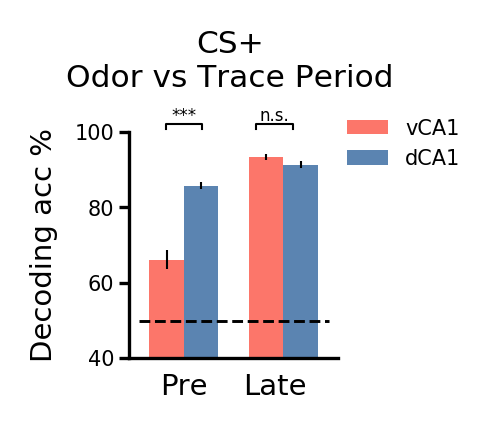

In [70]:
from matplotlib.patches import Patch
labels = ['Pre','Late']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.9,1))
for reg,c,i in zip(['vhpc','dhpc'],['#FC766AFF','#5B84B1FF'],[-width/2,+width/2]):
    v[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSp_%s['expo']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(0+i, np.mean(eval("baseline_scores_tb_8_CSp_%s['expo']"%(reg))[:loops])*100, width, color=c,yerr=v[reg])
    d[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSp_%s['post']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(1.1+i,  np.mean(eval("baseline_scores_tb_8_CSp_%s['post']"%(reg))[:loops])*100, width,color=c, yerr=d[reg])
ax.hlines(50,-.5,1.6, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=7)
ax.legend([Patch(facecolor='#FC766AFF'),Patch(facecolor='#5B84B1FF')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['expo','post'], range(2)):
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_vhpc[sess][:loops], baseline_scores_tb_8_CSp_dhpc[sess][:loops],
        -.2+i,0.2+i,102))
    print sess,report_stats(baseline_scores_tb_8_CSp_vhpc[sess][:loops], baseline_scores_tb_8_CSp_dhpc[sess][:loops])
        #max(np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS+\nOdor vs Trace Period',y=1.22,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_ExPo_CSp.pdf'%NOTEBOOK_NAME)

expo U = 16.0 p = 0.0112989519183 r = -0.574704893215
None
post U = 42.5 p = 0.595870750035 r = -0.126773138209
None


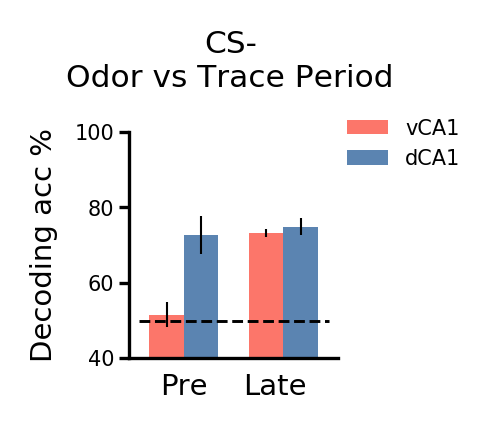

In [71]:
from matplotlib.patches import Patch
labels = ['Pre','Late']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.9,1))
for reg,c,i in zip(['vhpc','dhpc'],['#FC766AFF','#5B84B1FF'],[-width/2,+width/2]):
    v[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSm_%s['expo']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(0+i, np.mean(eval("baseline_scores_tb_8_CSm_%s['expo']"%(reg))[:loops])*100, width, color=c,yerr=v[reg])
    d[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSm_%s['post']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(1.1+i,  np.mean(eval("baseline_scores_tb_8_CSm_%s['post']"%(reg))[:loops])*100, width,color=c, yerr=d[reg])
ax.hlines(50,-.5,1.6, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=7)
ax.legend([Patch(facecolor='#FC766AFF'),Patch(facecolor='#5B84B1FF')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['expo','post'], range(2)):
    #pvs.append(add_significance(ax, baseline_scores_tb_8_CSm_vhpc[sess][:loops], baseline_scores_tb_8_CSm_dhpc[sess][:loops],
    #    -.2+i,0.2+i,102))
    print sess,report_stats(baseline_scores_tb_8_CSm_vhpc[sess][:loops], baseline_scores_tb_8_CSm_dhpc[sess][:loops])
        #max(np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS-\nOdor vs Trace Period',y=1.22,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_ExPo_CSm.pdf'%NOTEBOOK_NAME)

v WilcoxonResult(statistic=0.0, pvalue=0.0047808510011838421) r = -0.845154254729
None
d WilcoxonResult(statistic=0.0, pvalue=0.0050050744029052231) r = -0.845154254729
None


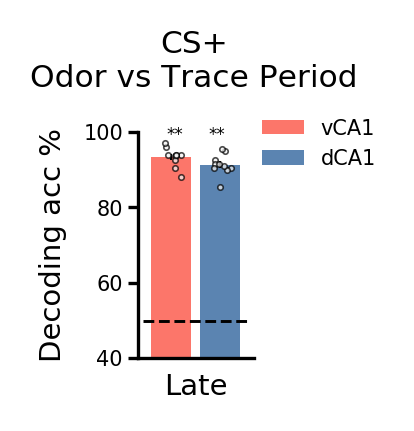

In [12]:
from matplotlib.patches import Patch
labels = ['Late']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.5,1))
for reg,c,i in zip(['vhpc','dhpc'],['#FC766AFF','#5B84B1FF'],[-width/2-.04,+width/2+.04]):
    d[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSp_%s['post']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(i,  np.mean(eval("baseline_scores_tb_8_CSp_%s['post']"%(reg))[:loops])*100, width,color=c, yerr=d[reg])
    ax.scatter(i+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_tb_8_CSp_%s['post']"%(reg))[:loops]*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
ax.hlines(50,-.5,.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=7)
ax.legend([Patch(facecolor='#FC766AFF'),Patch(facecolor='#5B84B1FF')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['post'], range(1)):
    pvs.append(sig_vs_chance(ax, baseline_scores_tb_8_CSp_vhpc[sess][:loops],0.5,-.2+i,98))
    pvs.append(sig_vs_chance(ax, baseline_scores_tb_8_CSp_dhpc[sess][:loops],0.5,0.2+i,98))
    print 'v',report_stats_chance(baseline_scores_tb_8_CSp_vhpc[sess][:loops])
    print 'd',report_stats_chance(baseline_scores_tb_8_CSp_dhpc[sess][:loops])

pl.suptitle('CS+\nOdor vs Trace Period',y=1.22,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_Po_CSp.pdf'%NOTEBOOK_NAME)

v WilcoxonResult(statistic=0.0, pvalue=0.0050335082006062494) r = -0.845154254729
None
d WilcoxonResult(statistic=0.0, pvalue=0.0050335082006062494) r = -0.845154254729
None


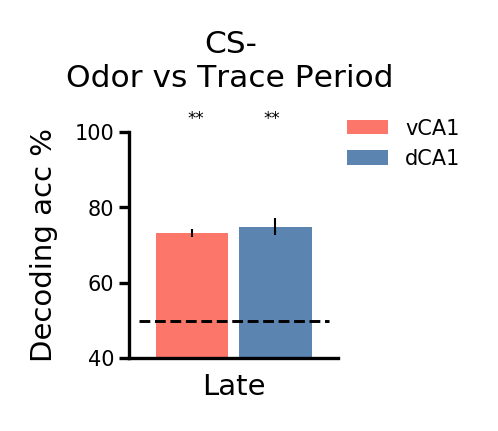

In [48]:
from matplotlib.patches import Patch
labels = ['Late']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.9,1))
for reg,c,i in zip(['vhpc','dhpc'],['#FC766AFF','#5B84B1FF'],[-width/2-.03,+width/2+.03]):
    d[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSm_%s['post']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(i,  np.mean(eval("baseline_scores_tb_8_CSm_%s['post']"%(reg))[:loops])*100, width,color=c, yerr=d[reg])
ax.hlines(50,-.5,.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=7)
ax.legend([Patch(facecolor='#FC766AFF'),Patch(facecolor='#5B84B1FF')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['post'], range(1)):
    pvs.append(sig_vs_chance(ax, baseline_scores_tb_8_CSm_vhpc[sess][:loops],0.5,-.2+i,102))
    pvs.append(sig_vs_chance(ax, baseline_scores_tb_8_CSm_dhpc[sess][:loops],0.5,0.2+i,102))
    print 'v',report_stats_chance(baseline_scores_tb_8_CSm_vhpc[sess][:loops])
    print 'd',report_stats_chance(baseline_scores_tb_8_CSm_dhpc[sess][:loops])
        #max(np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS-\nOdor vs Trace Period',y=1.22,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_Po_CSm.pdf'%NOTEBOOK_NAME)

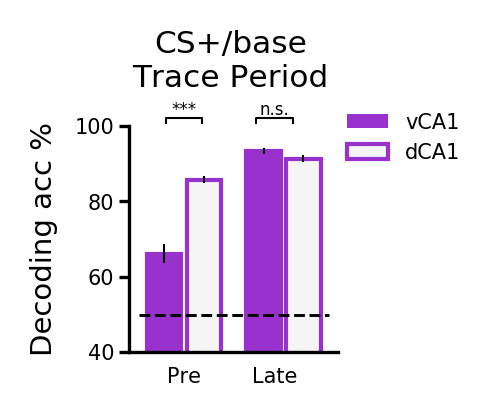

In [72]:
from matplotlib.patches import Patch
labels = ['Pre','Late']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.9,1))
for reg,c,i in zip(['vhpc','dhpc'],['darkorchid','whitesmoke'],[-width/2-.03,+width/2+.03]):
    v[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSp_%s['expo']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(0+i, np.mean(eval("baseline_scores_tb_8_CSp_%s['expo']"%(reg))[:loops])*100, width, color=c,edgecolor='darkorchid',yerr=v[reg])
    d[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSp_%s['post']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(1.1+i,  np.mean(eval("baseline_scores_tb_8_CSp_%s['post']"%(reg))[:loops])*100, width,color=c, edgecolor='darkorchid',yerr=d[reg])
ax.hlines(50,-.5,1.6, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='whitesmoke',edgecolor='darkorchid')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['expo','post'], range(2)):
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_vhpc[sess][:loops], baseline_scores_tb_8_CSp_dhpc[sess][:loops],
        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS+/base\nTrace Period',y=1.2,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_tr_ExPo_CSp_b.pdf'%NOTEBOOK_NAME)

expo U = 0.5 p = 0.000208707754624 r = -0.836702712181
None
post U = 71.5 p = 0.110246451916 r = 0.363416329533
None


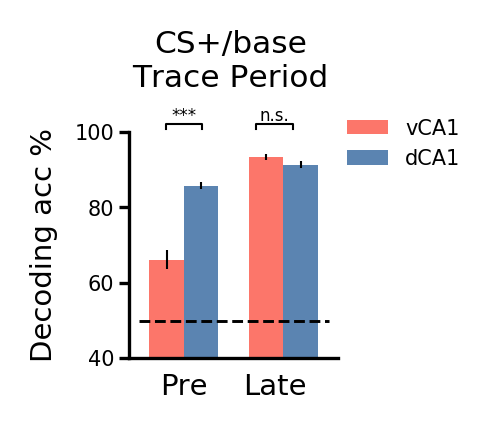

In [73]:
from matplotlib.patches import Patch
labels = ['Pre','Late']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,2]
fig, ax = pl.subplots(figsize=(.9,1))
for reg,c,i in zip(['vhpc','dhpc'],['#FC766AFF','#5B84B1FF'],[-width/2,+width/2]):
    v[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSp_%s['expo']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(0+i, np.mean(eval("baseline_scores_tb_8_CSp_%s['expo']"%(reg))[:loops])*100, width, color=c,yerr=v[reg])
    d[reg] = np.array(np.std(eval("baseline_scores_tb_8_CSp_%s['post']"%(reg))[:loops])/np.sqrt(loops)*100)
    ax.bar(1.1+i,  np.mean(eval("baseline_scores_tb_8_CSp_%s['post']"%(reg))[:loops])*100, width,color=c,yerr=d[reg])
ax.hlines(50,-.5,1.6, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=7)
ax.legend([Patch(facecolor='#FC766AFF'),Patch(facecolor='#5B84B1FF')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(['expo','post'], range(2)):
    pvs.append(add_significance(ax, baseline_scores_tb_8_CSp_vhpc[sess][:loops], baseline_scores_tb_8_CSp_dhpc[sess][:loops],
        -.2+i,0.2+i,102))
    print sess,report_stats(baseline_scores_tb_8_CSp_vhpc[sess][:loops], baseline_scores_tb_8_CSp_dhpc[sess][:loops])
        #max(np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('CS+/base\nTrace Period',y=1.22,fontsize=7.5)

fig.savefig('../final-ish figures/%s_gmin_bars_tr_ExPo_CSp_b.pdf'%NOTEBOOK_NAME)

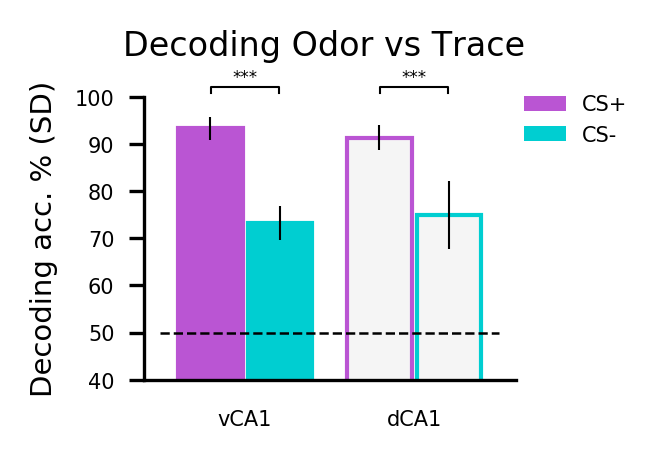

In [74]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10 # only use the first 10 entries of data

fig, ax = pl.subplots(figsize=(1.6,1.25))

#get standard deviation of data
v = np.array(np.std(baseline_scores_tb_8_CSp_vhpc['post'][:loops])*100)
#plot mean with error lines (yerr)
ax.bar(-width/2-.015, np.mean(baseline_scores_tb_8_CSp_vhpc['post'][:loops])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=v)

d = np.array(np.std(baseline_scores_tb_8_CSm_vhpc['post'][:loops])*100)
ax.bar(width/2+.015,  np.mean(baseline_scores_tb_8_CSm_vhpc['post'][:loops])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=d)
v = np.array(np.std(baseline_scores_tb_8_CSp_dhpc['post'][:loops])*100)
ax.bar(1 - width/2-.015, np.mean(baseline_scores_tb_8_CSp_dhpc['post'][:loops])*100, width, edgecolor='mediumorchid',color='whitesmoke',yerr=v)
d = np.array(np.std(baseline_scores_tb_8_CSm_dhpc['post'][:loops])*100)
ax.bar(1 + width/2+.015,  np.mean(baseline_scores_tb_8_CSm_dhpc['post'][:loops])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=d)

# add "chance" line
ax.hlines(50,-.5,1.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc. % (SD)')
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='mediumorchid'),Patch(facecolor='darkturquoise')],['CS+','CS-'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False) #remove tick marks from x axis

# perform stats and draw lines
pvs=[]
for reg,i in zip(['vhpc','dhpc'], range(2)):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_8_CSp_%s['post'][:loops]"%reg), eval("baseline_scores_tb_8_CSm_%s['post'][:loops]"%reg),
        -.2+i,0.2+i,102))

pl.suptitle('Decoding Odor vs Trace',y=1.06,fontsize=8)

#fig.savefig('../../../odor_ass_learning_2019/results/final-ish figures/TONE_%s_gmin_bars_tr_PrPo_b.pdf'%NOTEBOOK_NAME)

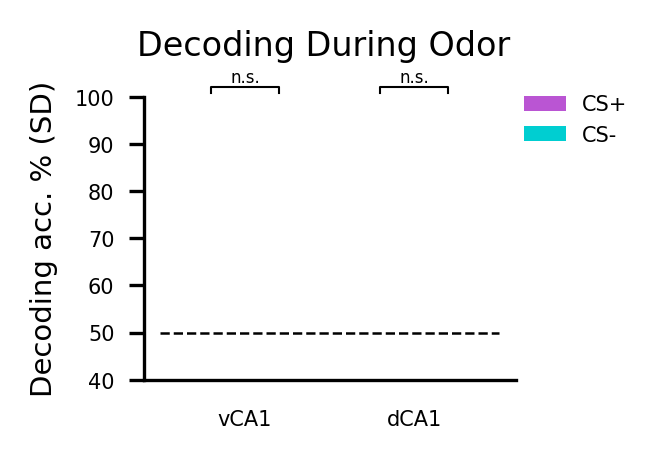

In [75]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1.6,1.25))
v[sess] = np.array(np.std(baseline_scores_tb_6_CSp_vhpc['post'][:loops])*100)
ax.bar(-width/2-.015, np.mean(baseline_scores_tb_6_CSp_vhpc['post'][:loops])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=v[sess])
d[sess] = np.array(np.std(baseline_scores_tb_6_CSm_vhpc['post'][:loops])*100)
ax.bar(width/2+.015,  np.mean(baseline_scores_tb_6_CSm_vhpc['post'][:loops])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=d[sess])
v[sess] = np.array(np.std(baseline_scores_tb_6_CSp_dhpc['post'][:loops])*100)
ax.bar(1 - width/2-.015, np.mean(baseline_scores_tb_6_CSp_dhpc['post'][:loops])*100, width, edgecolor='mediumorchid',color='whitesmoke',yerr=v[sess])
d[sess] = np.array(np.std(baseline_scores_tb_6_CSm_dhpc['post'][:loops])*100)
ax.bar(1 + width/2+.015,  np.mean(baseline_scores_tb_6_CSm_dhpc['post'][:loops])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=d[sess])
ax.hlines(50,-.5,1.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Decoding acc. % (SD)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='mediumorchid'),Patch(facecolor='darkturquoise')],['CS+','CS-'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for reg,i in zip(['vhpc','dhpc'], range(2)):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_CSp_%s['post'][:loops]"%reg), eval("baseline_scores_tb_6_CSm_%s['post'][:loops]"%reg),
        -.2+i,0.2+i,102))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding During Odor',y=1.06,fontsize=8)

#fig.savefig('../../../odor_ass_learning_2019/results/final-ish figures/TONE_%s_gmin_bars_tr_PrPo_b.pdf'%NOTEBOOK_NAME)

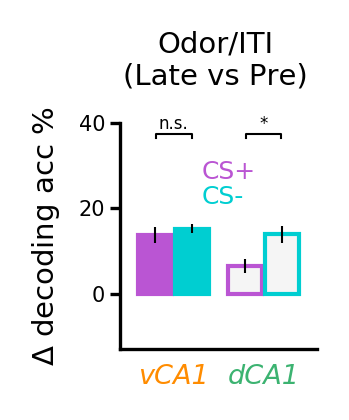

In [77]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(.85,1))
v[sess] = np.array(np.std(baseline_scores_tb_6_CSp_vhpc['post'][:loops]-baseline_scores_tb_6_CSp_vhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(-width/2-.015, np.mean(baseline_scores_tb_6_CSp_vhpc['post'][:loops]-baseline_scores_tb_6_CSp_vhpc['expo'][:loops])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=v[sess])
d[sess] = np.array(np.std(baseline_scores_tb_6_CSm_vhpc['post'][:loops]-baseline_scores_tb_6_CSm_vhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(width/2+.015,  np.mean(baseline_scores_tb_6_CSm_vhpc['post'][:loops]-baseline_scores_tb_6_CSm_vhpc['expo'][:loops])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=d[sess])
v[sess] = np.array(np.std(baseline_scores_tb_6_CSp_dhpc['post'][:loops]-baseline_scores_tb_6_CSp_dhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(1 - width/2-.015, np.mean(baseline_scores_tb_6_CSp_dhpc['post'][:loops]-baseline_scores_tb_6_CSp_dhpc['expo'][:loops])*100, width, edgecolor='mediumorchid',color='whitesmoke',yerr=v[sess])
d[sess] = np.array(np.std(baseline_scores_tb_6_CSm_dhpc['post'][:loops]-baseline_scores_tb_6_CSm_dhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(1 + width/2+.015,  np.mean(baseline_scores_tb_6_CSm_dhpc['post'][:loops]-baseline_scores_tb_6_CSm_dhpc['expo'][:loops])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=d[sess])
ax.hlines(50,-.5,1.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\Delta$ decoding acc %')
#ax.set_title('Decoding During CS')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(-13,40)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=6.5,fontstyle='italic')
ax.get_xticklabels()[0].set_color("darkorange")
ax.get_xticklabels()[1].set_color("mediumseagreen")
#ax.legend([Patch(facecolor='mediumorchid'),Patch(facecolor='darkturquoise')],['CS+','CS-'],loc=(.9,.7),frameon=False)
ax.text(.31,27,"CS+",ha='left',color='mediumorchid',fontsize=6)
ax.text(.31,21,"CS-",ha='left',color='darkturquoise',fontsize=6)
pvs=[]
for reg,i in zip(['vhpc','dhpc'], range(2)):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_CSp_%s['post'][:loops]-baseline_scores_tb_6_CSp_%s['expo'][:loops]"%(reg,reg)),
        eval("baseline_scores_tb_6_CSm_%s['post'][:loops]-baseline_scores_tb_6_CSm_%s['expo'][:loops]"%(reg,reg)),
        -.2+i,0.2+i,37.5))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_6_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Odor/ITI\n(Late vs Pre)',y=1.19,fontsize=7)

fig.savefig('../final-ish figures/%s_preVSlate_odor.pdf'%NOTEBOOK_NAME)

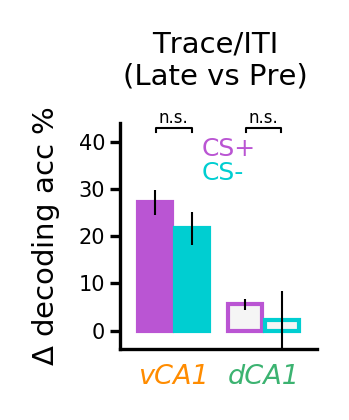

In [78]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops=10
v={}
d={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(.85,1))
v[sess] = np.array(np.std(baseline_scores_tb_8_CSp_vhpc['post'][:loops]-baseline_scores_tb_8_CSp_vhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(-width/2-.015, np.mean(baseline_scores_tb_8_CSp_vhpc['post'][:loops]-baseline_scores_tb_8_CSp_vhpc['expo'][:loops])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=v[sess])
d[sess] = np.array(np.std(baseline_scores_tb_8_CSm_vhpc['post'][:loops]-baseline_scores_tb_8_CSm_vhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(width/2+.015,  np.mean(baseline_scores_tb_8_CSm_vhpc['post'][:loops]-baseline_scores_tb_8_CSm_vhpc['expo'][:loops])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=d[sess])
v[sess] = np.array(np.std(baseline_scores_tb_8_CSp_dhpc['post'][:loops]-baseline_scores_tb_8_CSp_dhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(1 - width/2-.015, np.mean(baseline_scores_tb_8_CSp_dhpc['post'][:loops]-baseline_scores_tb_8_CSp_dhpc['expo'][:loops])*100, width, edgecolor='mediumorchid',color='whitesmoke',yerr=v[sess])
d[sess] = np.array(np.std(baseline_scores_tb_8_CSm_dhpc['post'][:loops]-baseline_scores_tb_8_CSm_dhpc['expo'][:loops])/np.sqrt(loops)*100)
ax.bar(1 + width/2+.015,  np.mean(baseline_scores_tb_8_CSm_dhpc['post'][:loops]-baseline_scores_tb_8_CSm_dhpc['expo'][:loops])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=d[sess])
ax.hlines(50,-.5,1.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\Delta$ decoding acc %')
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
ax.set_ylim(-4,44)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=6.5,fontstyle='italic')
ax.get_xticklabels()[0].set_color("darkorange")
ax.get_xticklabels()[1].set_color("mediumseagreen")
ax.text(.31,37,"CS+",ha='left',color='mediumorchid',fontsize=6)
ax.text(.31,32,"CS-",ha='left',color='darkturquoise',fontsize=6)
#ax.legend([Patch(facecolor='mediumorchid'),Patch(facecolor='darkturquoise')],['CS+','CS-'],loc=(.9,.7),frameon=False)
pvs=[]
for reg,i in zip(['vhpc','dhpc'], range(2)):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_8_CSp_%s['post'][:loops]-baseline_scores_tb_8_CSp_%s['expo'][:loops]"%(reg,reg)),
        eval("baseline_scores_tb_8_CSm_%s['post'][:loops]-baseline_scores_tb_8_CSm_%s['expo'][:loops]"%(reg,reg)),
        -.2+i,0.2+i,43))
        #max(np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_vhpc[sess][:loops],.5,-.2+i,
    #           np.mean(mean_scores_gmin_tb_8_vhpc[sess][:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,mean_scores_gmin_tb_8_dhpc[sess][:loops],.5, .2+i,
    #           np.mean(mean_scores_gmin_tb_8_dhpc[sess][:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Trace/ITI\n(Late vs Pre)',y=1.19,fontsize=7)

fig.savefig('../final-ish figures/%s_preVSlate_delay.pdf'%NOTEBOOK_NAME)

In [79]:
save_workspace(db)

Could not store variable 'matplotlib'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'np'. Skipping...
